# Bayesian Analysis on Digital Asset Data

### Background

Digital asset markets operate 24/7.<br/>
For a given asset e.g., BTC, ETH, multiple markes/pairs may exist.
The most actively traded ones ar spot and perptual markets.
- In spot markets, the actual asset is traded directly
- In perpetual markets, derivatives of the asset are traded.
  
Although the price in these markets are correlated, they are oten not identical.

---

**Bid and Ask** <br/>
There are twwo types of prices:
- The **bid** price represents the price that a buyer is willing to pay for an asset
- The **ask** price is the price that a seller is willing to accept
- The **best bid** is the highest among all bid offers in the market
- The **best ask** is the lowest among all ask offers

---
**Reaction Time**

On Binance, the reaction tim between these two markets is typically around 3-5 milliseconds (ms). A sudden price movement in one market is usually rflected in the other within 3-5 ms. However, not every price movement is reliable - some revert to their original level before affecting the other market.

### Objectives
#### Primary Objective: Generate signals for 
- i) spot trading by considering price movements in perpetual prices
- ii) perpetual trading by considering price movements in spot prices. You need to predict the price that will be reached in one market within 5 ms, based on sudden price changes observed in the other one. 

#### Secondary Objectives: 
- Identify whether the spot or perpetual market more often leads price discovery. Which 
one drives the other one most? 
- Detect and characterize noise events—sudden price changes that do not affect the other 
market. 
- Estimate the momentum quality of the sudden price changes. You are encouraged to 
explore how long a price movement sustains its momentum—either in terms of time 
duration or price delta.  For example, in the chart below, the movement in the red 
region shows high initial momentum but fades quickly, whereas the movement in the 
blue region, despite having lower intensity, persists over a longer period. 

#### Dataset

The data used is TRB/USDT pair

In [1]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import xarray as xr
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from IPython.display import Image, display

In [2]:
pio.renderers.default="notebook"

In [3]:
df_spot = pd.read_csv('./data/trb_usdt_futures_export.csv')
df_spot_trade = pd.read_csv('./data/trb_usdt_trades_export.csv')
df_perpetual = pd.read_csv('./data/trb_usdt_spot_export.csv')

In [4]:
df_spot['time'] = pd.to_datetime(df_spot['time'], format='mixed', errors='coerce')
df_spot_trade['time'] = pd.to_datetime(df_spot_trade['time'], format='mixed', errors='coerce')
df_perpetual['time'] = pd.to_datetime(df_perpetual['time'], format='mixed', errors='coerce')

In [5]:
print(df_spot['time'].isna().sum())
print(df_spot_trade['time'].isna().sum())
print(df_perpetual['time'].isna().sum())

0
0
0


In [6]:
df_spot.info(), df_spot_trade.info(), df_perpetual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5593820 entries, 0 to 5593819
Data columns (total 4 columns):
 #   Column     Dtype              
---  ------     -----              
 0   time       datetime64[ns, UTC]
 1   symbol     object             
 2   bid_price  float64            
 3   ask_price  float64            
dtypes: datetime64[ns, UTC](1), float64(2), object(1)
memory usage: 170.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291966 entries, 0 to 291965
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   time             291966 non-null  datetime64[ns, UTC]
 1   symbol           291966 non-null  object             
 2   price            291966 non-null  float64            
 3   quantity         291966 non-null  float64            
 4   is_market_maker  291966 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(2)
memory usage: 11.

(None, None, None)

### Add Timedelta in MS

In [7]:
df_spot = df_spot.sort_values('time').reset_index(drop=True)
df_spot_trade=df_spot_trade.sort_values('time').reset_index(drop=True)
df_perpetual=df_perpetual.sort_values('time').reset_index(drop=True)

In [8]:
df_spot['mid_price'] = (df_spot['bid_price']+df_spot['ask_price'])/2
df_perpetual['mid_price'] = (df_perpetual['bid_price']+df_perpetual['ask_price'])/2

### Merge Spot and Spot Trade Data

In [9]:
df_spot_merged = pd.merge_asof(
    df_spot_trade,
    df_spot[['time', 'bid_price', 'ask_price', 'mid_price']],
    on='time',
    direction='backward'
)

In [10]:
df_spot_merged.head()

,time,symbol,price,quantity,is_market_maker,bid_price,ask_price,mid_price
0,2025-05-27 12:00:00.382000+00:00,TRB_USDT,43.16,6.750,t,43.138,43.141,43.1395
1,2025-05-27 12:00:00.523000+00:00,TRB_USDT,43.15,7.950,t,43.138,43.141,43.1395
2,2025-05-27 12:00:01.824000+00:00,TRB_USDT,43.17,0.199,t,43.138,43.141,43.1395
3,2025-05-27 12:00:02.490000+00:00,TRB_USDT,43.16,1.010,t,43.127,43.137,43.1320
4,2025-05-27 12:00:04.225000+00:00,TRB_USDT,43.15,4.678,t,43.117,43.119,43.1180


In [11]:
df_spot_merged.shape, df_spot.shape

((291966, 8), (5593820, 5))

### Add Features in Spot Merged Data

In [12]:
def compute_pct_change_window(time_ns, mid_price, window_ms, tolerance_ms=0.5):
    target_ns = int(window_ms * 1e6)
    tolerance_ns = int(tolerance_ms * 1e6)

    future_idx = np.searchsorted(time_ns, time_ns + target_ns)
    
    pct_change = np.full(len(time_ns), np.nan)

    for i, j in enumerate(future_idx):
        if j >= len(time_ns):
            continue
        actual_delta = time_ns[j] - time_ns[i]
        if abs(actual_delta - target_ns) <= tolerance_ns and mid_price[i] != 0:
            pct_change[i] = (mid_price[j] - mid_price[i]) / mid_price[i] * 100

    return pct_change


In [13]:
df_spot_merged['price_dev'] = df_spot_merged['price'] - df_spot_merged['mid_price']
df_spot_merged['trade_direction'] = np.where(df_spot_merged['price'] > df_spot_merged['mid_price'], 1,-1)
df_spot_merged['signed_volume'] = df_spot_merged['trade_direction'] * df_spot_merged['quantity']
df_spot_merged["window_3_pct_change"] = compute_pct_change_window(df_spot_merged['time'].values.astype('int64'), 
                                                                  df_spot_merged['mid_price'].values, 3)
df_spot_merged["window_5_pct_change"] = compute_pct_change_window(df_spot_merged['time'].values.astype('int64'),
                                                                  df_spot_merged['mid_price'].values, 5)

In [14]:
df_spot_merged.set_index('time', inplace=True)

### Add Rolling Window Features

In [15]:
df_spot_merged['timedelta_ms'] = df_spot_merged.sort_index().index.to_series().diff().dt.total_seconds() * 1000
df_spot_merged['rolling_signed_volume_3ms'] = df_spot_merged['signed_volume'].rolling('3ms').sum().fillna(0)
df_spot_merged['rolling_signed_volume_5ms'] = df_spot_merged['signed_volume'].rolling('5ms').sum().fillna(0)
# df_spot_merged['window_3'] = df_spot_merged['mid_price'].rolling('3ms').mean()
# df_spot_merged['window_5'] = df_spot_merged['mid_price'].rolling('5ms').mean()
# df_spot_merged['window_3_pct_change'] = df_spot_merged['window_3'].pct_change() * 100
# df_spot_merged['window_5_pct_change'] = df_spot_merged['window_5'].pct_change() * 100

## Spot Data

In [16]:
df_spot_merged.describe().T

,count,mean,std,min,25%,50%,75%,max
price,291966.0,50.414154,2.806320,43.060000,48.990000,50.6800,52.220000,56.870000
quantity,291966.0,2.360075,7.934132,0.001000,0.198000,0.6480,3.249750,2065.834000
bid_price,291966.0,50.387088,2.805252,43.019000,48.979000,50.6590,52.198000,56.817000
ask_price,291966.0,50.404853,2.807347,43.020000,48.999000,50.6730,52.215000,56.851000
mid_price,291966.0,50.395971,2.806200,43.019500,48.989000,50.6655,52.205000,56.828500
price_dev,291966.0,0.018183,0.058428,-1.786500,0.006000,0.0195,0.033000,1.046500
trade_direction,291966.0,0.648541,0.761181,-1.000000,1.000000,1.0000,1.000000,1.000000
signed_volume,291966.0,1.372575,8.163116,-2065.834000,0.147000,0.2370,2.000000,1329.076000
window_3_pct_change,40373.0,-0.003998,0.141766,-3.374152,-0.032676,0.0000,0.029467,1.908306
window_5_pct_change,35131.0,-0.011322,0.185906,-2.219393,-0.053995,0.0000,0.044262,1.838210


In [17]:
df_spot_merged.head()

,symbol,price,quantity,is_market_maker,bid_price,ask_price,mid_price,price_dev,trade_direction,signed_volume,window_3_pct_change,window_5_pct_change,timedelta_ms,rolling_signed_volume_3ms,rolling_signed_volume_5ms
time,,,,,,,,,,,,,,,
2025-05-27 12:00:00.382000+00:00,TRB_USDT,43.16,6.750,t,43.138,43.141,43.1395,0.0205,1,6.750,NaN,NaN,NaN,6.750,6.750
2025-05-27 12:00:00.523000+00:00,TRB_USDT,43.15,7.950,t,43.138,43.141,43.1395,0.0105,1,7.950,NaN,NaN,141.0,7.950,7.950
2025-05-27 12:00:01.824000+00:00,TRB_USDT,43.17,0.199,t,43.138,43.141,43.1395,0.0305,1,0.199,NaN,NaN,1301.0,0.199,0.199
2025-05-27 12:00:02.490000+00:00,TRB_USDT,43.16,1.010,t,43.127,43.137,43.1320,0.0280,1,1.010,NaN,NaN,666.0,1.010,1.010
2025-05-27 12:00:04.225000+00:00,TRB_USDT,43.15,4.678,t,43.117,43.119,43.1180,0.0320,1,4.678,NaN,NaN,1735.0,4.678,4.678


In [18]:
df_spot_merged = df_spot_merged.reset_index()

In [19]:
df_spot_merged.head()

,time,symbol,price,quantity,is_market_maker,bid_price,ask_price,mid_price,price_dev,trade_direction,signed_volume,window_3_pct_change,window_5_pct_change,timedelta_ms,rolling_signed_volume_3ms,rolling_signed_volume_5ms
0,2025-05-27 12:00:00.382000+00:00,TRB_USDT,43.16,6.750,t,43.138,43.141,43.1395,0.0205,1,6.750,NaN,NaN,NaN,6.750,6.750
1,2025-05-27 12:00:00.523000+00:00,TRB_USDT,43.15,7.950,t,43.138,43.141,43.1395,0.0105,1,7.950,NaN,NaN,141.0,7.950,7.950
2,2025-05-27 12:00:01.824000+00:00,TRB_USDT,43.17,0.199,t,43.138,43.141,43.1395,0.0305,1,0.199,NaN,NaN,1301.0,0.199,0.199
3,2025-05-27 12:00:02.490000+00:00,TRB_USDT,43.16,1.010,t,43.127,43.137,43.1320,0.0280,1,1.010,NaN,NaN,666.0,1.010,1.010
4,2025-05-27 12:00:04.225000+00:00,TRB_USDT,43.15,4.678,t,43.117,43.119,43.1180,0.0320,1,4.678,NaN,NaN,1735.0,4.678,4.678


/home/lucky/anaconda3/envs/python311/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




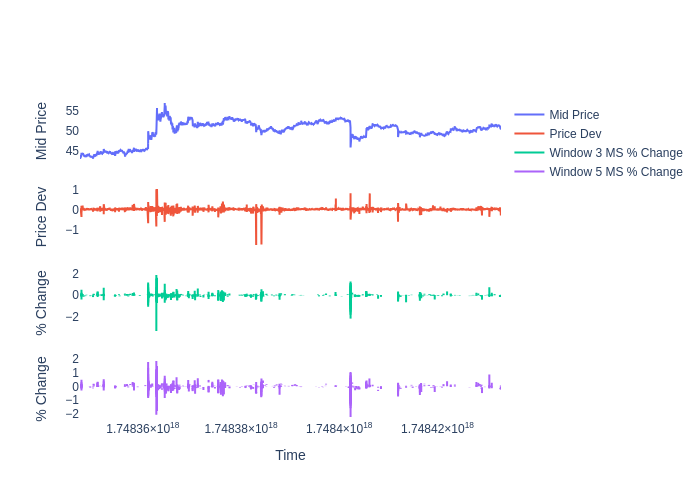

In [20]:
fig = make_subplots(cols=1,rows=4, shared_xaxes=True)

fig.add_trace(
    go.Line(x=df_spot_merged.time,
           y=df_spot_merged.mid_price,
           name='Mid Price'
           ), col=1, row=1
)

fig.add_trace(
    go.Line(x=df_spot_merged.time,
           y=df_spot_merged.price_dev,
           name='Price Dev'
           ), col=1, row=2
)


fig.add_trace(
    go.Line(
        x=df_spot_merged.time,
        y=df_spot_merged.window_3_pct_change,
        name='Window 3 MS % Change'
    ), col=1, row=3
)

fig.add_trace(
    go.Line(
        x=df_spot_merged.time,
        y=df_spot_merged.window_5_pct_change,
        name='Window 5 MS % Change'
    ), col=1, row=4
)

fig.update_layout(
    xaxis4_title='Time',
    yaxis_title='Mid Price',
    yaxis2_title='Price Dev',
    yaxis3_title='% Change',
    yaxis4_title='% Change',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    height=800,
    showlegend=True
)

fig.write_image("./data/plot1.png")
display(Image("./data/plot1.png"))

# Uncomment below fig for interactive plot in your local
# fig.show() 

### Model Building

The objective of this model is to determine the **Sudden Price Changes** on Each Market (Spot and Perpetual)

In [21]:
features = [
    'timedelta_ms',
    'trade_direction',
    'mid_price',
    'price_dev',
    'rolling_signed_volume_3ms',
    'rolling_signed_volume_5ms'
]
target = 'window_3_pct_change'

In [22]:
df_model = df_spot_merged[features + ['window_3_pct_change']].dropna().reset_index(drop=True)

In [23]:
df_sample = df_model.sample(30000, random_state=42)
df_sample.head()

,timedelta_ms,trade_direction,mid_price,price_dev,rolling_signed_volume_3ms,rolling_signed_volume_5ms,window_3_pct_change
6134,0.0,-1,48.2320,-0.1220,-55.756,-55.756,-0.232211
32237,0.0,1,46.0225,0.3475,18.538,65.125,-0.142322
6039,3.0,1,49.1095,0.0705,4.069,4.569,0.001018
8477,0.0,1,50.4020,0.0180,0.248,0.298,0.034721
39517,0.0,1,51.0065,0.0235,-0.204,-0.204,0.000000


In [24]:
# X_data = df_sample[features].values
scaler = StandardScaler()
X_data = scaler.fit_transform(df_sample[features].values)
y_data = df_sample[target].values

In [25]:
with pm.Model() as model_3ms:
    # priors
    a = pm.Normal('a', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X_data.shape[1])
    sigma = pm.HalfNormal('sigma', 1)

    # linear model
    u = pm.Deterministic('mu', a+pm.math.dot(X_data, beta))

    # likelihood
    y_pred = pm.Normal('y', mu=u, sigma=sigma, observed=y_data)

    # inference
    idata_3ms = pm.sample(idata_kwargs={'log_likelihood':True})
    idata_3ms.extend(pm.sample_posterior_predictive(idata_3ms))

Initializing NUTS using jitter+adapt_diag...
INFO	pymc.sampling.mcmc:mcmc.py:init_nuts()- Initializing NUTS using jitter+adapt_diag...
/home/lucky/anaconda3/envs/python311/lib/python3.11/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning:

PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library

Multiprocess sampling (4 chains in 4 jobs)
INFO	pymc.sampling.mcmc:mcmc.py:sample()- Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, sigma]
INFO	pymc.s

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
INFO	pymc.sampling.mcmc:mcmc.py:_sample_return()- Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: [y]
INFO	pymc.sampling.forward:forward.py:sample_posterior_predictive()- Sampling: [y]


Output()

### Visual Representation of Linear 3ms Model

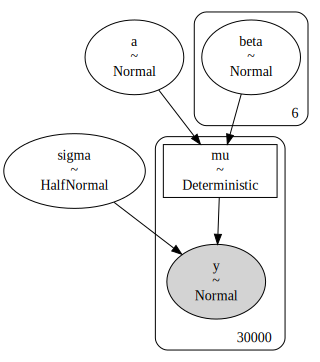

In [26]:
pm.model_to_graphviz(model_3ms)

### Posterior Check

In [27]:
idata_3ms.posterior

<xarray.Dataset> Size: 961MB
Dimensions:     (chain: 4, draw: 1000, beta_dim_0: 6, mu_dim_0: 30000)
Coordinates:
  * chain       (chain) int64 32B 0 1 2 3
  * draw        (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * beta_dim_0  (beta_dim_0) int64 48B 0 1 2 3 4 5
  * mu_dim_0    (mu_dim_0) int64 240kB 0 1 2 3 4 ... 29996 29997 29998 29999
Data variables:
    a           (chain, draw) float64 32kB -0.003495 -0.005609 ... -0.005717
    beta        (chain, draw, beta_dim_0) float64 192kB 0.0008377 ... -0.007538
    sigma       (chain, draw) float64 32kB 0.1342 0.133 0.1338 ... 0.134 0.1336
    mu          (chain, draw, mu_dim_0) float64 960MB -0.07308 ... -0.02672
Attributes:
    created_at:                 2025-06-30T11:14:24.263059+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.23.0
    sampling_time:              4.622657060623169
    tuning_steps:               1000

/home/lucky/anaconda3/envs/python311/lib/python3.11/site-packages/arviz/utils.py:146: UserWarning:

Items starting with ~: ['posterior_mean'] have not been found and will be ignored



[]

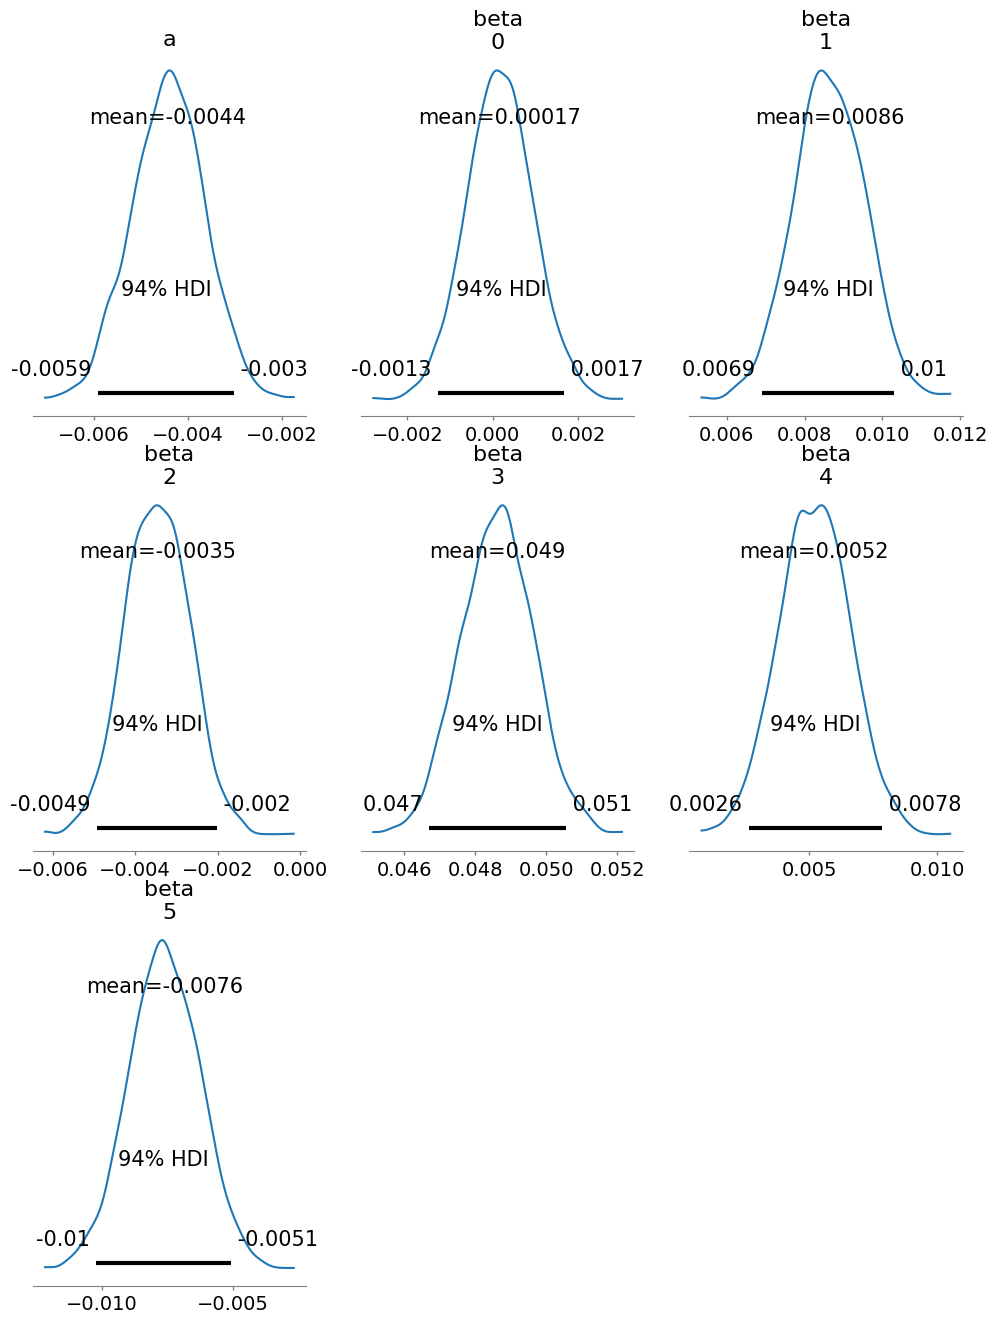

In [28]:
az.plot_posterior(idata_3ms, var_names=['~posterior_mean','~mu','~sigma'], figsize=(12,16))
plt.plot()

[]

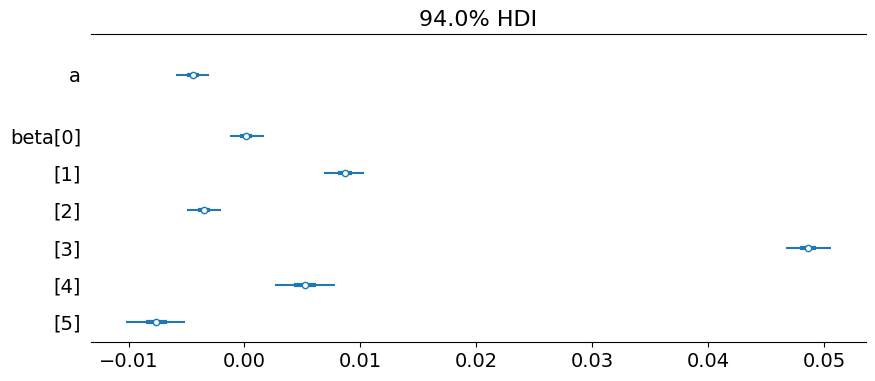

In [29]:
az.plot_forest(idata_3ms, var_names=['a', 'beta'], combined=True, figsize=(10,4))
plt.plot()

In [30]:
mu_mean = idata_3ms.posterior["mu"].mean(dim=("mu_dim_0"))  # shape: [chain, draw]
idata_3ms.posterior['posterior_mean'] = mu_mean

In [31]:
az.summary(idata_3ms, var_names=['a', 'beta', 'sigma','posterior_mean'], round_to=5, kind='stats')

,mean,sd,hdi_3%,hdi_97%
a,-0.00443,0.00078,-0.00591,-0.00303
beta[0],0.00017,0.00078,-0.00129,0.00167
beta[1],0.00864,0.00092,0.00689,0.01031
beta[2],-0.00347,0.00078,-0.00492,-0.00203
beta[3],0.04861,0.00103,0.04670,0.05055
beta[4],0.00520,0.00138,0.00265,0.00782
beta[5],-0.00761,0.00135,-0.01021,-0.00509
sigma,0.13358,0.00055,0.13255,0.13462
posterior_mean,-0.00443,0.00078,-0.00591,-0.00303


In [32]:
spot_population_mean_3pct_change = np.mean(df_spot_merged['window_3_pct_change']) * 100
print(f"Mean percentage change of spot population: {spot_population_mean_3pct_change:.8f}%")

Mean percentage change of spot population: -0.39982321%


[]

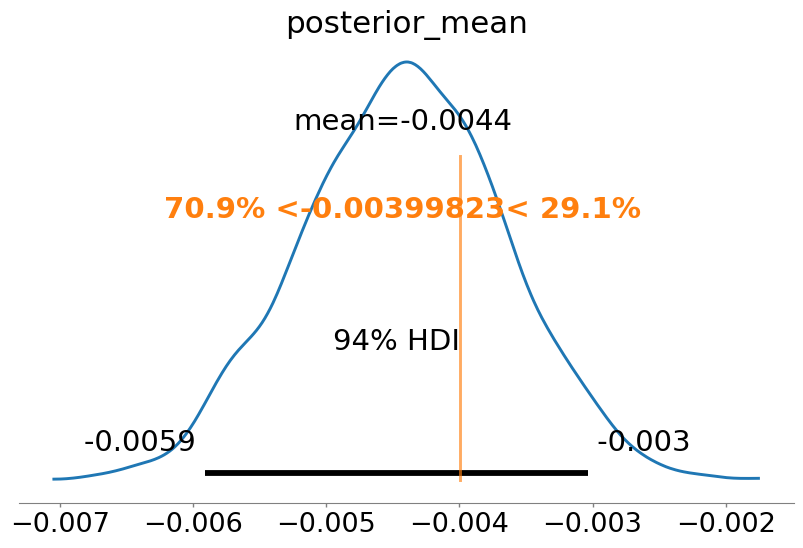

In [33]:
az.plot_posterior(idata_3ms, var_names=['posterior_mean'], figsize=(10,6), ref_val=-0.0039982321)
plt.plot()

- The curve above shows that the mean percentage change within a 3 ms window is approximately 0.015%, with 94% probability that the true mean lies between -0.014% and 0.049%.
- The lower bound of the 94% highest density interval (HDI) is negative, suggesting the possibility of a slight decrease in price, while the upper bound indicates a potential slight increase.
- The population mean of the spot percentage change (in 3ms window) is 0.0058%, which falls within the 94% HDI and is very close to the posterior mean, supporting the model's validity.

Sampling: [y]
INFO	pymc.sampling.forward:forward.py:sample_posterior_predictive()- Sampling: [y]


Output()

(-0.2, 0.2)

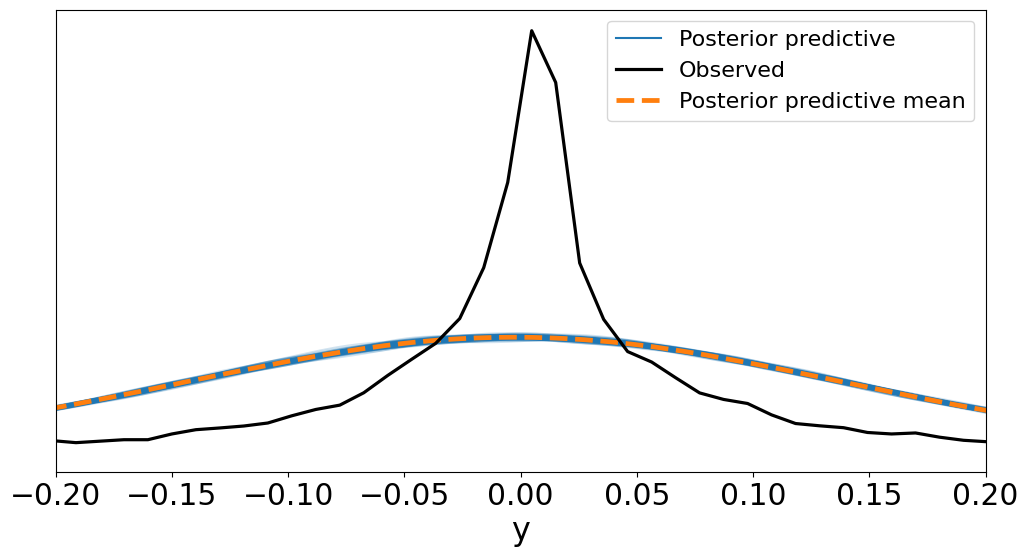

In [34]:
pm.sample_posterior_predictive(idata_3ms, model=model_3ms, random_seed=42)
ax = az.plot_ppc(idata_3ms, num_pp_samples=200, figsize=(12,6))

ax.set_xlim(-0.2,0.2)

In [35]:
features = [
    'timedelta_ms',
    'mid_price',
    'price_dev',
    'rolling_signed_volume_3ms',
    'rolling_signed_volume_5ms',
    'trade_direction'
]

target = 'window_5_pct_change'

df_model = df_spot_merged[features + [target]].dropna().reset_index(drop=True)
df_sample = df_model.sample(30000, random_state=42)

# X_data = df_sample[features].values
scaler = StandardScaler()
X_data = scaler.fit_transform(df_sample[features].values)
y_data = df_sample[target].values

with pm.Model() as model_5ms_l:
    # priors
    a = pm.Normal('a', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X_data.shape[1])
    sigma = pm.HalfNormal('sigma', 1)

    # linear model
    u = pm.Deterministic('mu', a+pm.math.dot(X_data, beta))

    # likelihood
    y_pred = pm.Normal('y', mu=u, sigma=sigma, observed=y_data)

    # inference
    idata_5ms_l = pm.sample(idata_kwargs={'log_likelihood':True})
    idata_5ms_l.extend(pm.sample_posterior_predictive(idata_5ms_l))

Initializing NUTS using jitter+adapt_diag...
INFO	pymc.sampling.mcmc:mcmc.py:init_nuts()- Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO	pymc.sampling.mcmc:mcmc.py:sample()- Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, sigma]
INFO	pymc.sampling.mcmc:mcmc.py:_print_step_hierarchy()- NUTS: [a, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
INFO	pymc.sampling.mcmc:mcmc.py:_sample_return()- Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [y]
INFO	pymc.sampling.forward:forward.py:sample_posterior_predictive()- Sampling: [y]


Output()

In [36]:
features = [
    'timedelta_ms',
    'mid_price',
    'price_dev',
    'rolling_signed_volume_3ms',
    'rolling_signed_volume_5ms',
    'trade_direction'
]

target = 'window_5_pct_change'

df_model = df_spot_merged[features + [target]].dropna().reset_index(drop=True)
df_sample = df_model.sample(30000, random_state=42)

# X_data = df_sample[features].values
scaler = StandardScaler()
X_data = scaler.fit_transform(df_sample[features].values)
y_data = df_sample[target].values

with pm.Model() as model_5ms_t:
    # priors
    a = pm.Normal('a', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X_data.shape[1])
    sigma = pm.HalfNormal('sigma', 1)

    v_ = pm.Exponential("v_", 1/29) 
    v = pm.Deterministic("v", v_+1) # weakly informative prior

    # linear model
    u = pm.Deterministic('mu', a+pm.math.dot(X_data, beta))

    # likelihood
    y_pred = pm.StudentT('y', mu=u, sigma=sigma, nu=v, observed=y_data)

    # inference
    idata_5ms_t = pm.sample(idata_kwargs={'log_likelihood':True})
    idata_5ms_t.extend(pm.sample_posterior_predictive(idata_5ms_t))

Initializing NUTS using jitter+adapt_diag...
INFO	pymc.sampling.mcmc:mcmc.py:init_nuts()- Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO	pymc.sampling.mcmc:mcmc.py:sample()- Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, sigma, v_]
INFO	pymc.sampling.mcmc:mcmc.py:_print_step_hierarchy()- NUTS: [a, beta, sigma, v_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
INFO	pymc.sampling.mcmc:mcmc.py:_sample_return()- Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
Sampling: [y]
INFO	pymc.sampling.forward:forward.py:sample_posterior_predictive()- Sampling: [y]


Output()

### Visual Representation of 5ms Linear Model

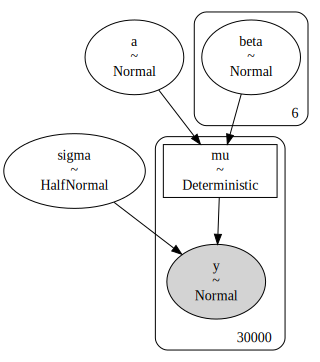

In [37]:
pm.model_to_graphviz(model_5ms_l)

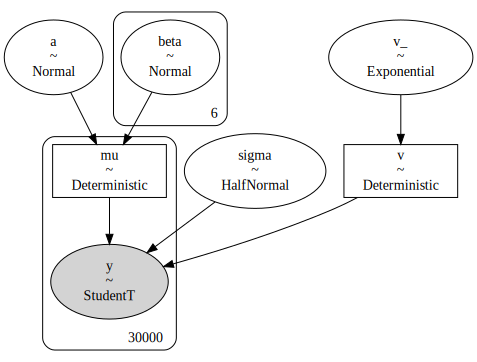

In [38]:
pm.model_to_graphviz(model_5ms_t)

/home/lucky/anaconda3/envs/python311/lib/python3.11/site-packages/arviz/utils.py:146: UserWarning:

Items starting with ~: ['posterior_mean'] have not been found and will be ignored



[]

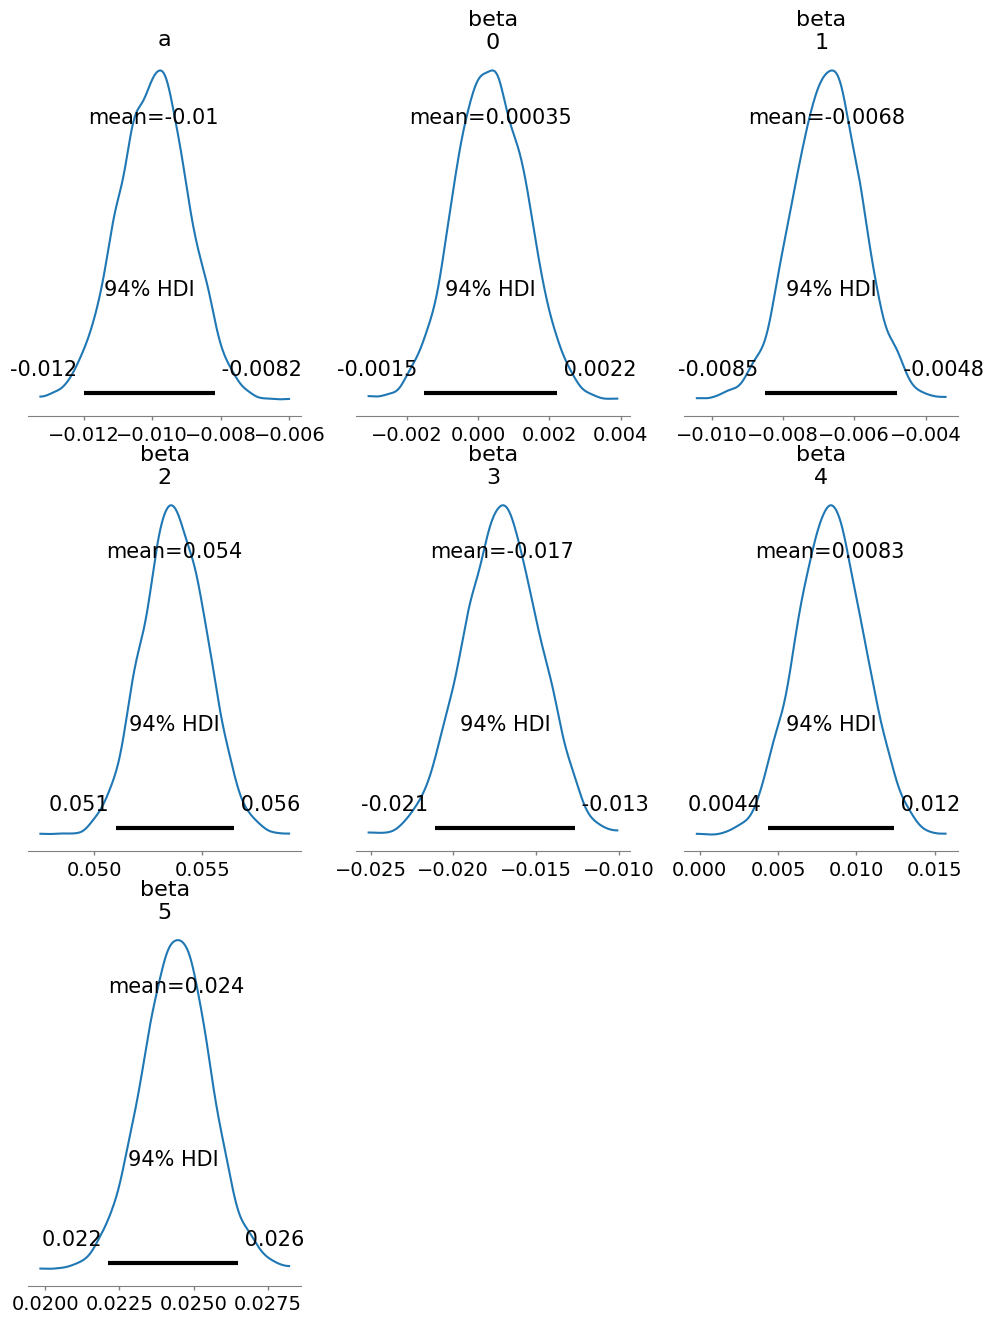

In [39]:
az.plot_posterior(idata_5ms_l, var_names=['~posterior_mean','~mu','~sigma'], figsize=(12,16))
plt.plot()

[]

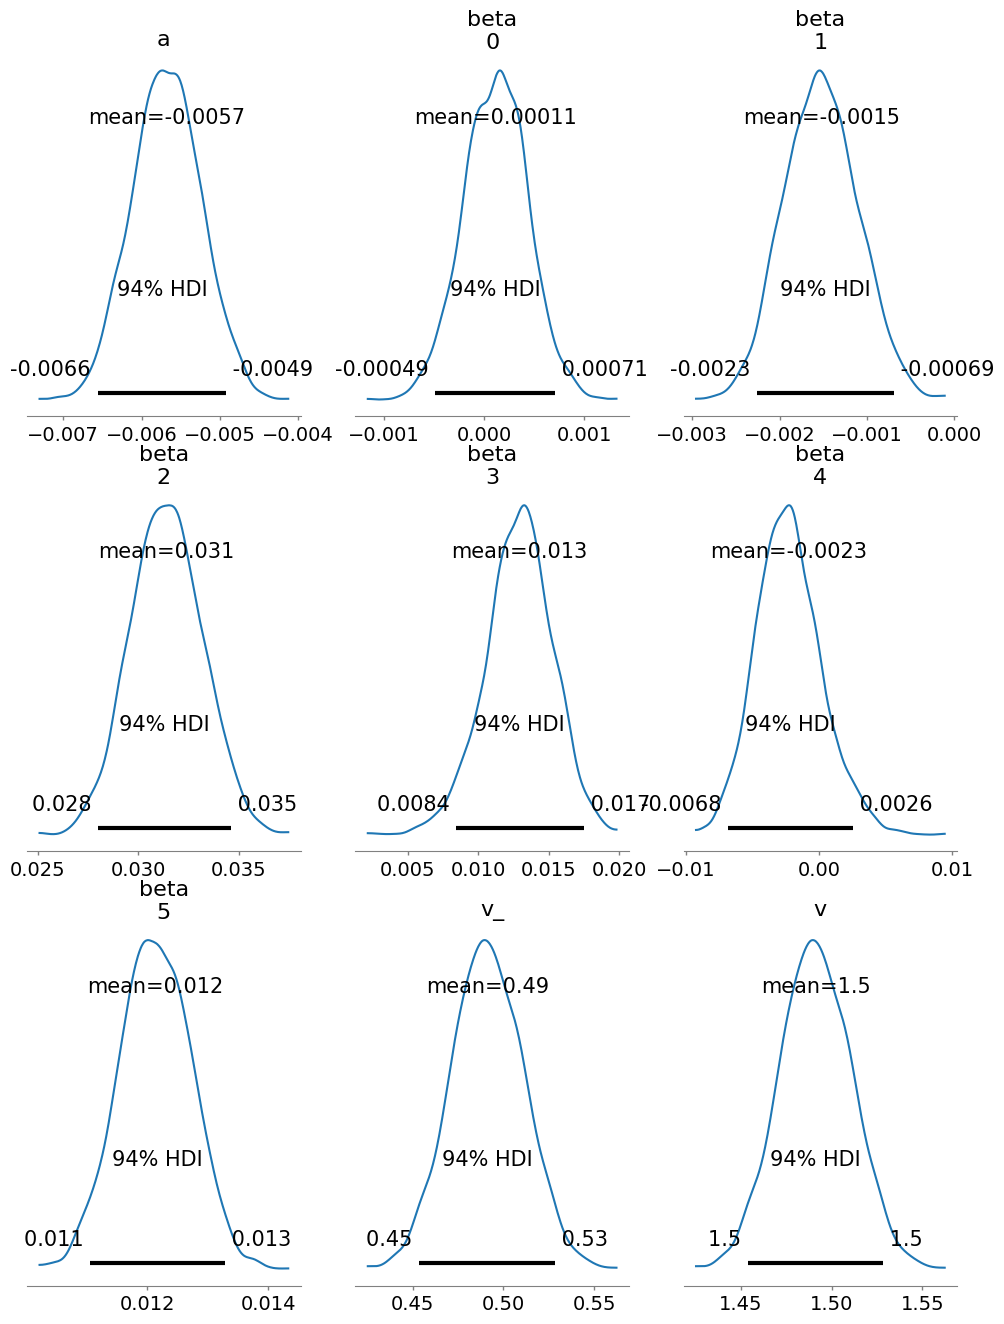

In [40]:
az.plot_posterior(idata_5ms_t, var_names=['~posterior_mean','~mu','~sigma'], figsize=(12,16))
plt.plot()

[]

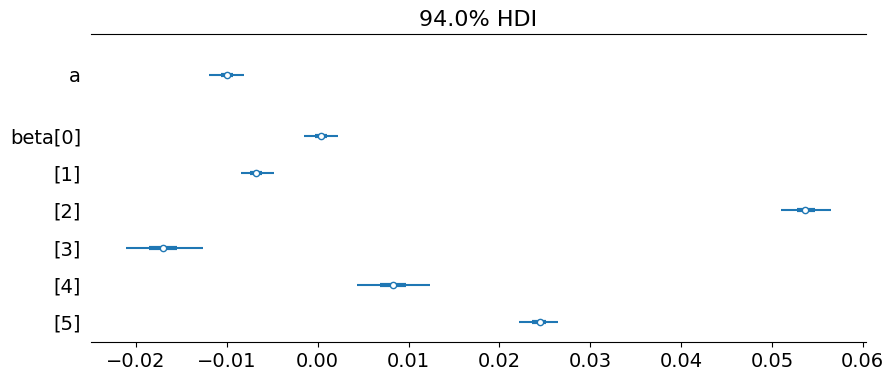

In [41]:
az.plot_forest(idata_5ms_l, var_names=['a', 'beta'], combined=True, figsize=(10,4))
plt.plot()

[]

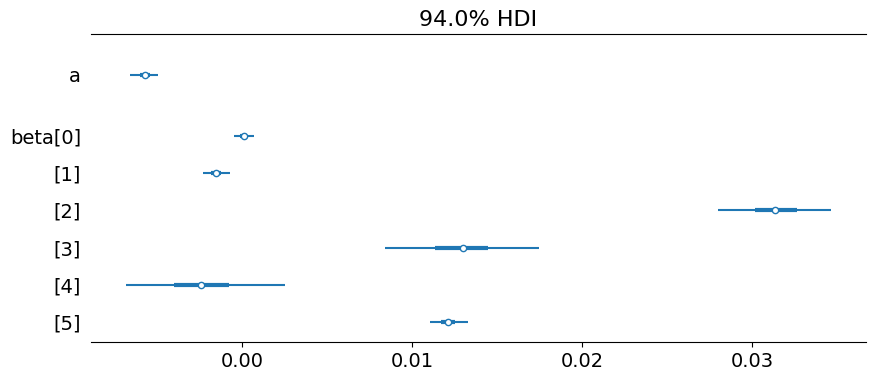

In [42]:
az.plot_forest(idata_5ms_t, var_names=['a', 'beta'], combined=True, figsize=(10,4))
plt.plot()

In [43]:
mu_mean = idata_5ms_l.posterior["mu"].mean(dim=("mu_dim_0"))  # shape: [chain, draw]
idata_5ms_l.posterior['posterior_mean'] = mu_mean

In [44]:
az.summary(idata_5ms_l, var_names=['a', 'beta', 'sigma','posterior_mean'], round_to=5, kind='stats')

,mean,sd,hdi_3%,hdi_97%
a,-0.00996,0.00102,-0.01200,-0.00817
beta[0],0.00035,0.00099,-0.00150,0.00221
beta[1],-0.00677,0.00097,-0.00850,-0.00481
beta[2],0.05369,0.00147,0.05099,0.05646
beta[3],-0.01708,0.00227,-0.02110,-0.01266
beta[4],0.00831,0.00216,0.00436,0.01239
beta[5],0.02441,0.00116,0.02213,0.02649
sigma,0.17328,0.00070,0.17194,0.17458
posterior_mean,-0.00996,0.00102,-0.01200,-0.00817


In [45]:
mu_mean = idata_5ms_t.posterior["mu"].mean(dim=("mu_dim_0"))  # shape: [chain, draw]
idata_5ms_t.posterior['posterior_mean'] = mu_mean

In [46]:
az.summary(idata_5ms_t, var_names=['a', 'beta', 'sigma','posterior_mean'], round_to=5, kind='stats')

,mean,sd,hdi_3%,hdi_97%
a,-0.00568,0.00044,-0.00656,-0.00492
beta[0],0.00011,0.00032,-0.00049,0.00071
beta[1],-0.00152,0.00042,-0.00226,-0.00069
beta[2],0.03141,0.00177,0.02798,0.03462
beta[3],0.01287,0.00239,0.00841,0.01745
beta[4],-0.00228,0.00246,-0.00681,0.00255
beta[5],0.01213,0.00060,0.01105,0.01328
sigma,0.05652,0.00056,0.05541,0.05751
posterior_mean,-0.00568,0.00044,-0.00656,-0.00492


In [47]:
spot_population_mean_5pct_change = np.mean(df_spot_merged['window_5_pct_change']) * 100
print(f"Mean percentage change of spot population: {spot_population_mean_5pct_change:.8f}%")

Mean percentage change of spot population: -1.13221577%


[]

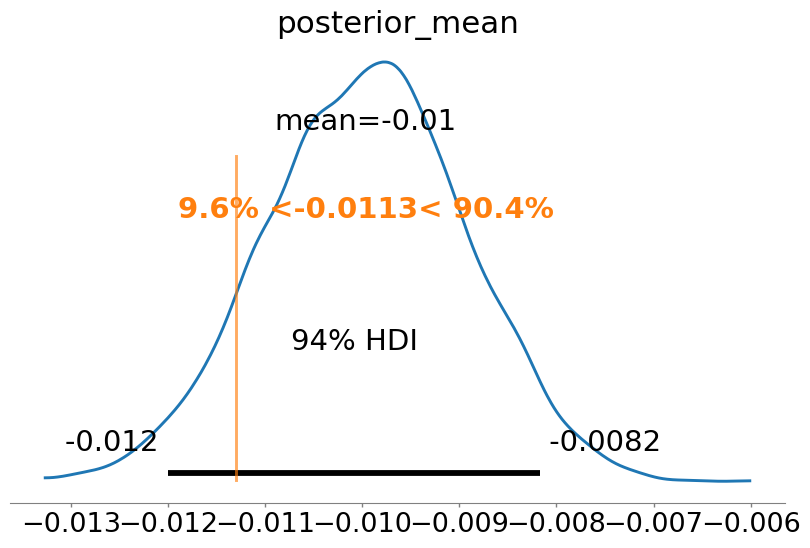

In [48]:
az.plot_posterior(idata_5ms_l, var_names=['posterior_mean'], figsize=(10,6), ref_val=-0.0113)
plt.plot()

[]

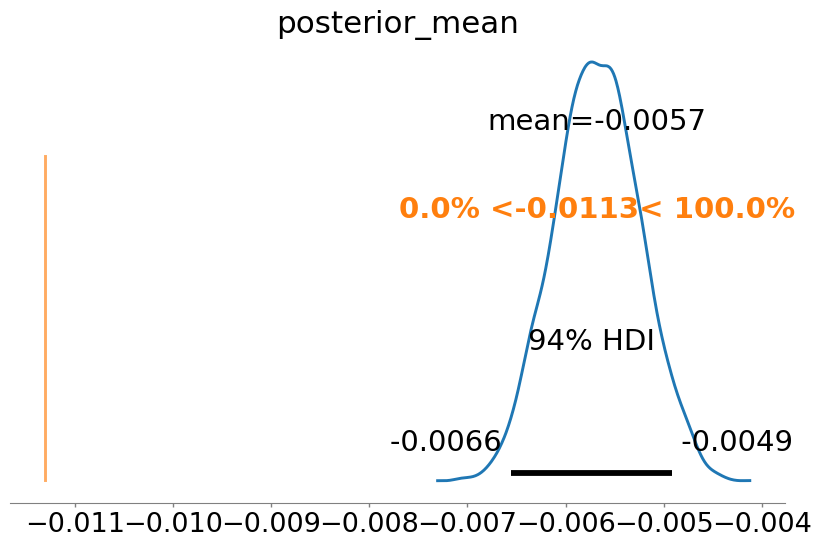

In [49]:
az.plot_posterior(idata_5ms_t, var_names=['posterior_mean'], figsize=(10,6), ref_val=-0.0113)
plt.plot()

[]

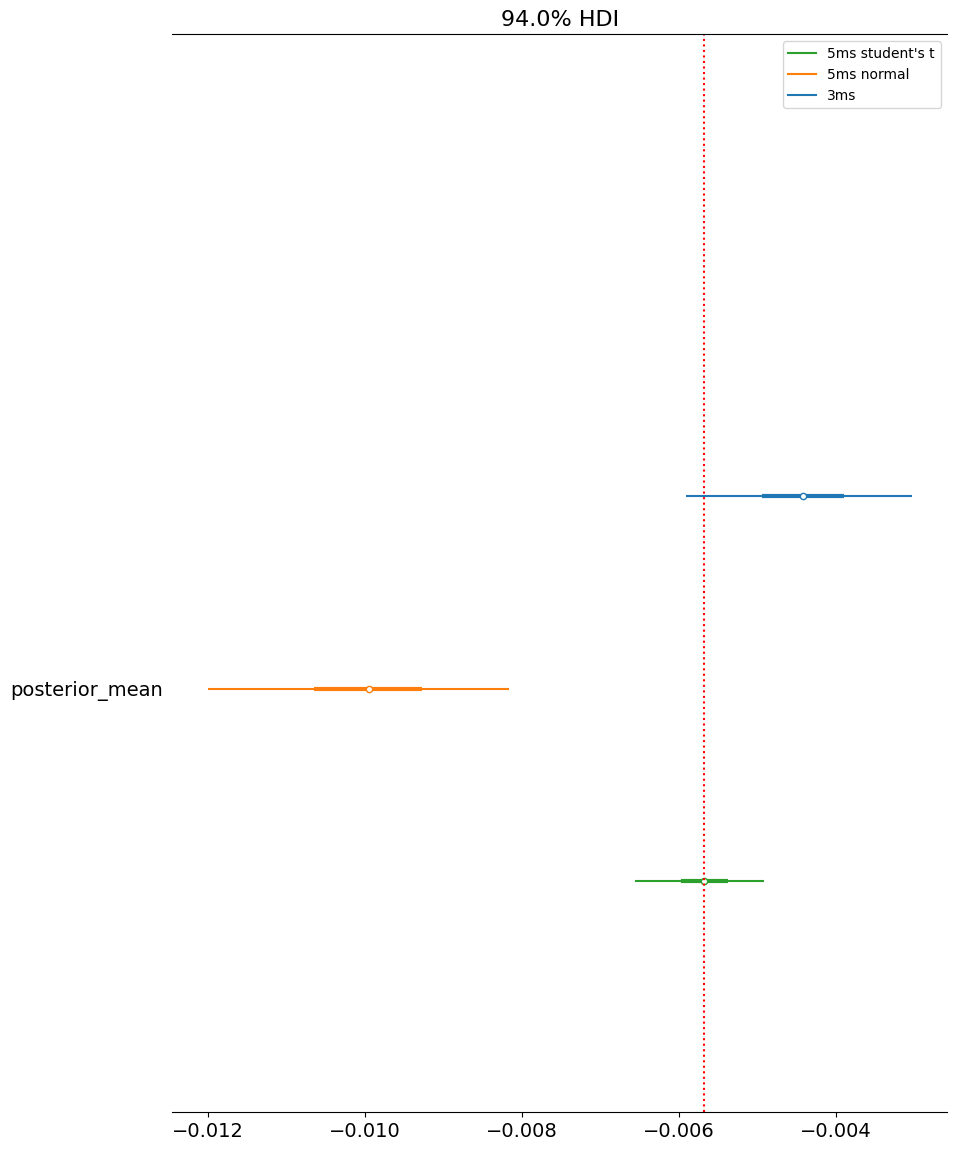

In [50]:
axes = az.plot_forest(data=[idata_3ms, idata_5ms_l, idata_5ms_t], 
               model_names=['3ms','5ms normal', "5ms student's t"], figsize=(10,14),
               combined=True,
               var_names=['posterior_mean'],
               r_hat=False,
               ess=False
              )

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_5ms_t.posterior['posterior_mean'].mean(), *y_lims, color='red', ls=":")
plt.plot()

The 5ms window linear regression model with a Student's t-likelihood shows a significantly narrower uncertainty compared to the other model.

Sampling: [y]
INFO	pymc.sampling.forward:forward.py:sample_posterior_predictive()- Sampling: [y]


Output()

(-0.1, 0.1)

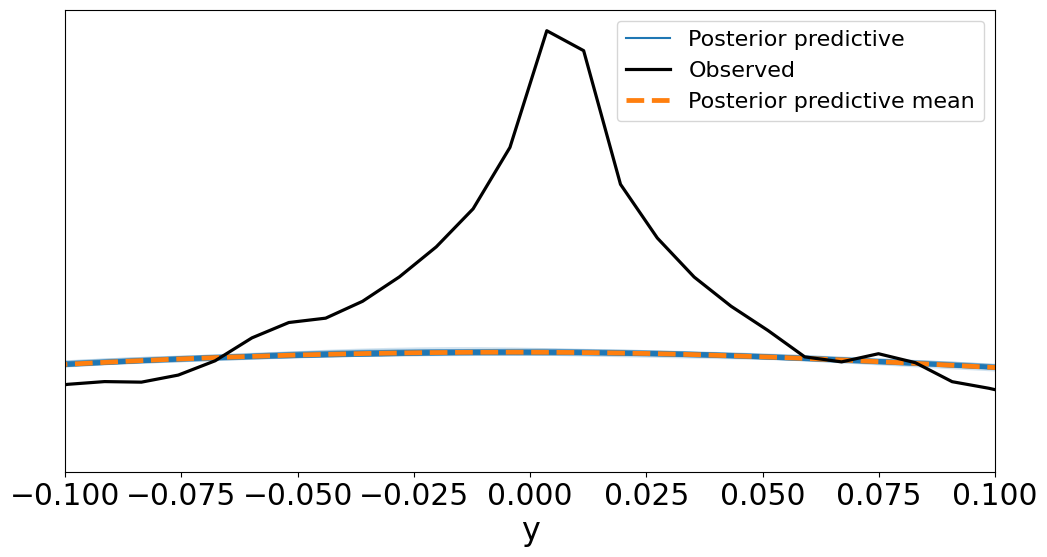

In [51]:
pm.sample_posterior_predictive(idata_5ms_l, model=model_5ms_l, random_seed=42)
ax = az.plot_ppc(idata_5ms_l, num_pp_samples=100, figsize=(12,6))
ax.set_xlim(-0.1, 0.1)

Sampling: [y]
INFO	pymc.sampling.forward:forward.py:sample_posterior_predictive()- Sampling: [y]


Output()

(-0.1, 0.1)

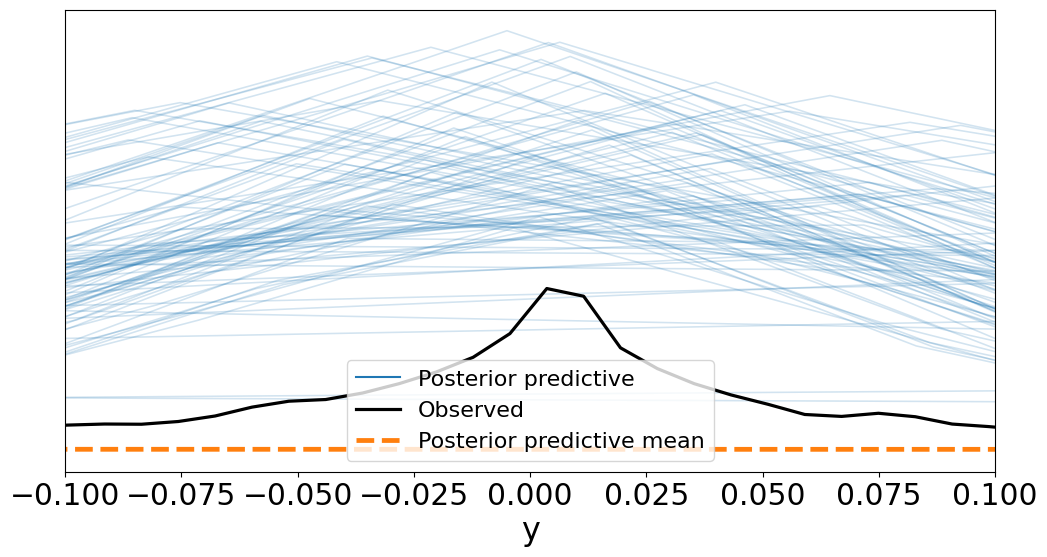

In [52]:
pm.sample_posterior_predictive(idata_5ms_t, model=model_5ms_t, random_seed=42)
ax = az.plot_ppc(idata_5ms_t, num_pp_samples=100, figsize=(12,6))
ax.set_xlim(-0.1, 0.1)

In [53]:
compare = az.compare(dict(model_3ms=idata_3ms, model_5ms_l=idata_5ms_l, model_5ms_t=idata_5ms_t),ic='loo')

In [54]:
compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_5ms_t,0,21558.093049,15.944678,0.000000,0.528874,236.971231,0.000000,False,log
model_3ms,1,17799.631846,46.747491,3758.461203,0.471329,636.352193,677.786779,False,log
model_5ms_l,2,10007.186274,25.178554,11550.906775,0.000000,422.431842,340.898657,False,log


[]

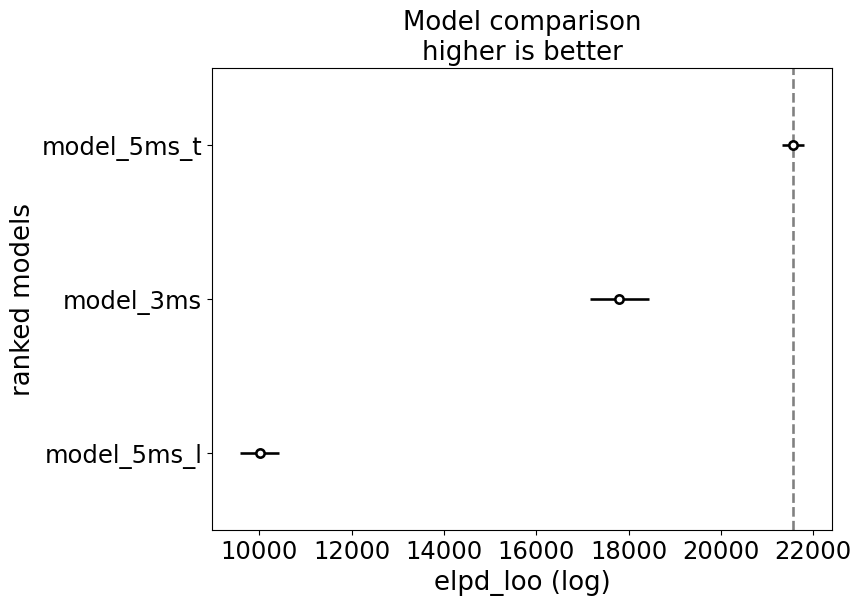

In [55]:
az.plot_compare(compare, figsize=(8,6))
plt.plot()

## Perpetual Data

In [56]:
df_perpetual.head()

,time,symbol,bid_price,ask_price,mid_price
0,2025-05-27 12:00:00.354000+00:00,TRB_USDT,43.15,43.17,43.160
1,2025-05-27 12:00:00.360000+00:00,TRB_USDT,43.16,43.17,43.165
2,2025-05-27 12:00:00.382000+00:00,TRB_USDT,43.15,43.17,43.160
3,2025-05-27 12:00:00.384000+00:00,TRB_USDT,43.16,43.17,43.165
4,2025-05-27 12:00:00.391000+00:00,TRB_USDT,43.15,43.17,43.160


In [57]:
df_final_merged = pd.merge_asof(df_spot_merged,
                                df_perpetual[['time', 'bid_price', 'ask_price', 'mid_price']],
                                on='time',
                                direction='backward',
                               suffixes=('_spot', '_perp'))

In [58]:
df_final_merged.head()

,time,symbol,price,quantity,is_market_maker,bid_price_spot,ask_price_spot,mid_price_spot,price_dev,trade_direction,signed_volume,window_3_pct_change,window_5_pct_change,timedelta_ms,rolling_signed_volume_3ms,rolling_signed_volume_5ms,bid_price_perp,ask_price_perp,mid_price_perp
0,2025-05-27 12:00:00.382000+00:00,TRB_USDT,43.16,6.750,t,43.138,43.141,43.1395,0.0205,1,6.750,NaN,NaN,NaN,6.750,6.750,43.15,43.17,43.160
1,2025-05-27 12:00:00.523000+00:00,TRB_USDT,43.15,7.950,t,43.138,43.141,43.1395,0.0105,1,7.950,NaN,NaN,141.0,7.950,7.950,43.15,43.16,43.155
2,2025-05-27 12:00:01.824000+00:00,TRB_USDT,43.17,0.199,t,43.138,43.141,43.1395,0.0305,1,0.199,NaN,NaN,1301.0,0.199,0.199,43.16,43.17,43.165
3,2025-05-27 12:00:02.490000+00:00,TRB_USDT,43.16,1.010,t,43.127,43.137,43.1320,0.0280,1,1.010,NaN,NaN,666.0,1.010,1.010,43.16,43.17,43.165
4,2025-05-27 12:00:04.225000+00:00,TRB_USDT,43.15,4.678,t,43.117,43.119,43.1180,0.0320,1,4.678,NaN,NaN,1735.0,4.678,4.678,43.14,43.15,43.145


In [59]:
df_final_merged['trade_direction_perp'] = np.where(df_final_merged['price'] > df_final_merged['mid_price_perp'], 1,-1)
df_final_merged["window_3_pct_change_perp"] = compute_pct_change_window(df_final_merged['time'].values.astype('int64'), 
                                                                   df_final_merged['mid_price_perp'].values, 3)
df_final_merged["window_5_pct_change_perp"] = compute_pct_change_window(df_final_merged['time'].values.astype('int64'), 
                                                                   df_final_merged['mid_price_perp'].values, 5)


# df_final_merged['window_3_perp'] = df_final_merged['mid_price_perp'].rolling('3ms').mean()
# df_final_merged['window_5_perp'] = df_final_merged['mid_price_perp'].rolling('5ms').mean()
# df_final_merged['window_3_pct_change_perp'] = df_final_merged['window_3_perp'].pct_change() * 100
# df_final_merged['window_5_pct_change_perp'] = df_final_merged['window_5_perp'].pct_change() * 100

In [60]:
df_final_merged.set_index('time', inplace=True)

In [61]:
df_final_merged['timedelta_ms_perp'] = df_final_merged.sort_index().index.to_series().diff().dt.total_seconds() * 1000


In [62]:
df_final_merged = df_final_merged.reset_index()

In [63]:
df_final_merged.head()

,time,symbol,price,quantity,is_market_maker,bid_price_spot,ask_price_spot,mid_price_spot,price_dev,trade_direction,...,timedelta_ms,rolling_signed_volume_3ms,rolling_signed_volume_5ms,bid_price_perp,ask_price_perp,mid_price_perp,trade_direction_perp,window_3_pct_change_perp,window_5_pct_change_perp,timedelta_ms_perp
0,2025-05-27 12:00:00.382000+00:00,TRB_USDT,43.16,6.750,t,43.138,43.141,43.1395,0.0205,1,...,NaN,6.750,6.750,43.15,43.17,43.160,-1,NaN,NaN,NaN
1,2025-05-27 12:00:00.523000+00:00,TRB_USDT,43.15,7.950,t,43.138,43.141,43.1395,0.0105,1,...,141.0,7.950,7.950,43.15,43.16,43.155,-1,NaN,NaN,141.0
2,2025-05-27 12:00:01.824000+00:00,TRB_USDT,43.17,0.199,t,43.138,43.141,43.1395,0.0305,1,...,1301.0,0.199,0.199,43.16,43.17,43.165,1,NaN,NaN,1301.0
3,2025-05-27 12:00:02.490000+00:00,TRB_USDT,43.16,1.010,t,43.127,43.137,43.1320,0.0280,1,...,666.0,1.010,1.010,43.16,43.17,43.165,-1,NaN,NaN,666.0
4,2025-05-27 12:00:04.225000+00:00,TRB_USDT,43.15,4.678,t,43.117,43.119,43.1180,0.0320,1,...,1735.0,4.678,4.678,43.14,43.15,43.145,1,NaN,NaN,1735.0


/home/lucky/anaconda3/envs/python311/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




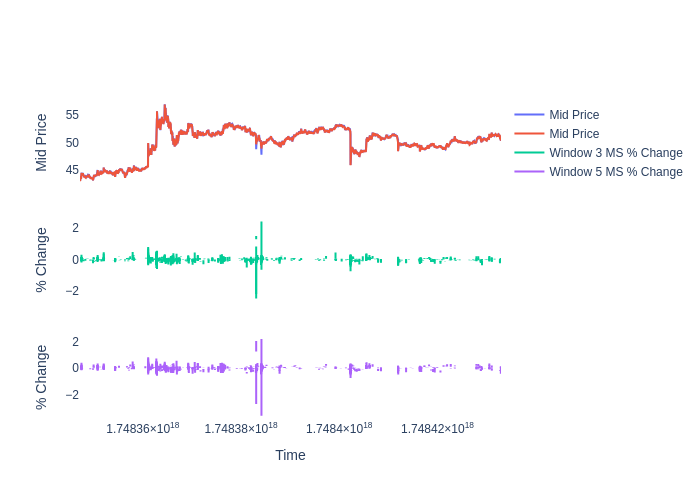

In [64]:
fig = make_subplots(cols=1,rows=3, shared_xaxes=True)

fig.add_trace(
    go.Line(x=df_final_merged.time,
           y=df_final_merged.mid_price_perp,
           name='Mid Price'
           ), col=1, row=1
)

fig.add_trace(
    go.Line(x=df_final_merged.time,
           y=df_final_merged.mid_price_spot,
           name='Mid Price'
           ), col=1, row=1
)

fig.add_trace(
    go.Line(
        x=df_final_merged.time,
        y=df_final_merged.window_3_pct_change_perp,
        name='Window 3 MS % Change'
    ), col=1, row=2
)

fig.add_trace(
    go.Line(
        x=df_final_merged.time,
        y=df_final_merged.window_5_pct_change_perp,
        name='Window 5 MS % Change'
    ), col=1, row=3
)

fig.update_layout(
    xaxis3_title='Time',
    yaxis_title='Mid Price',
    yaxis2_title='% Change',
    yaxis3_title='% Change',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    height=800,
    showlegend=True
)

fig.write_image("./data/plot2.png")
display(Image("./data/plot2.png"))

# Uncomment below fig for interactive plot in your local
# fig.show() 

The mid price between spot and perpetual are highly correlated and generally very similar

In [65]:
features = [
    'timedelta_ms_perp',
    'mid_price_perp',
    'trade_direction_perp',
]
target = 'window_3_pct_change_perp'

In [66]:
df_model = df_final_merged[features + [target]].dropna().reset_index(drop=True)

In [67]:
df_sample = df_model.sample(30000, random_state=42)
df_sample.head()

# X_data = df_sample[features].values
scaler = StandardScaler()
X_data = scaler.fit_transform(df_sample[features].values)
y_data = df_sample[target].values

with pm.Model() as model_3ms_perp:
    # priors
    a = pm.Normal('a', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X_data.shape[1])
    sigma = pm.HalfNormal('sigma', 1)

    # linear model
    u = pm.Deterministic('mu', a+pm.math.dot(X_data, beta))

    # likelihood
    y_pred = pm.Normal('y', mu=u, sigma=sigma, observed=y_data)

    # inference
    idata_3ms_perp = pm.sample(idata_kwargs={'log_likelihood':True})
    idata_3ms_perp.extend(pm.sample_posterior_predictive(idata_3ms_perp))

Initializing NUTS using jitter+adapt_diag...
INFO	pymc.sampling.mcmc:mcmc.py:init_nuts()- Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO	pymc.sampling.mcmc:mcmc.py:sample()- Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, sigma]
INFO	pymc.sampling.mcmc:mcmc.py:_print_step_hierarchy()- NUTS: [a, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
INFO	pymc.sampling.mcmc:mcmc.py:_sample_return()- Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]
INFO	pymc.sampling.forward:forward.py:sample_posterior_predictive()- Sampling: [y]


Output()

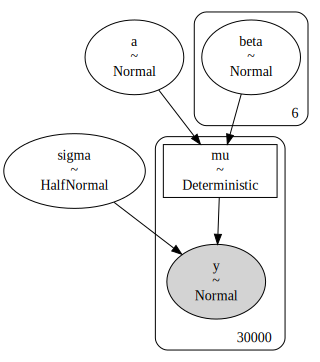

In [68]:
pm.model_to_graphviz(model_3ms)

/home/lucky/anaconda3/envs/python311/lib/python3.11/site-packages/arviz/utils.py:146: UserWarning:

Items starting with ~: ['posterior_mean'] have not been found and will be ignored



[]

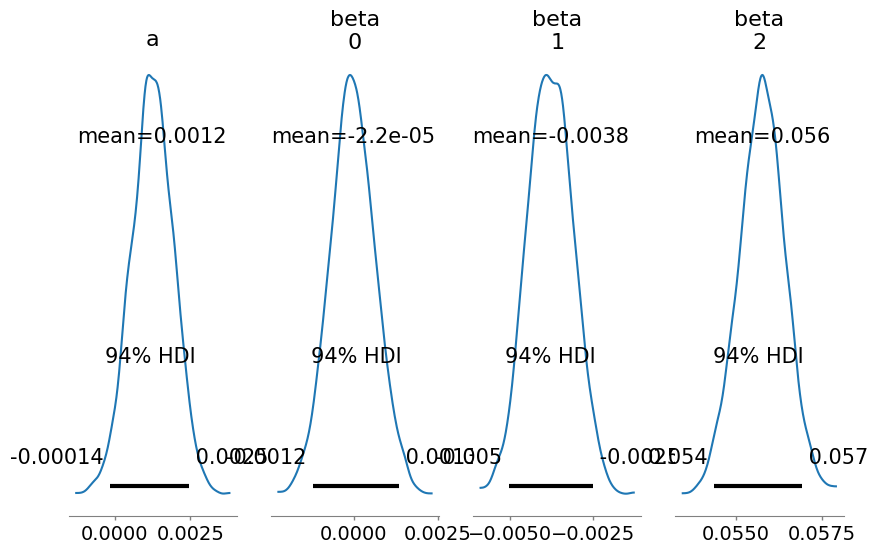

In [69]:
az.plot_posterior(idata_3ms_perp, var_names=['~posterior_mean','~mu','~sigma'], figsize=(10,6))
plt.plot()

[]

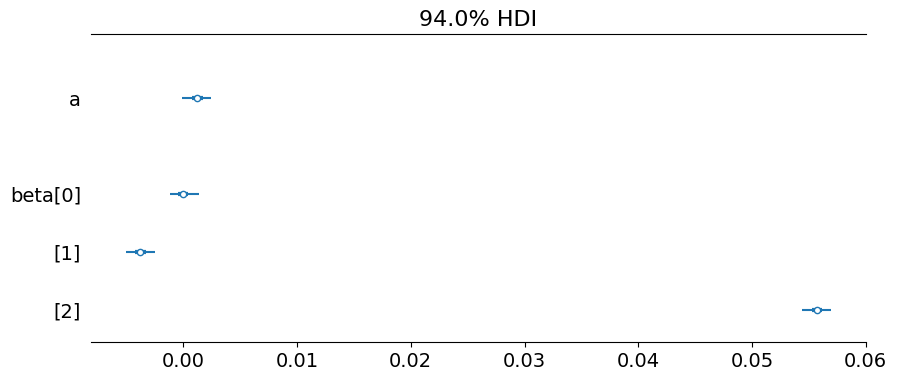

In [70]:
az.plot_forest(idata_3ms_perp, var_names=['a', 'beta'], combined=True, figsize=(10,4))
plt.plot()

In [71]:
mu_mean = idata_3ms_perp.posterior["mu"].mean(dim=("mu_dim_0"))  # shape: [chain, draw]
idata_3ms_perp.posterior['posterior_mean'] = mu_mean

In [72]:
az.summary(idata_3ms_perp, var_names=['a', 'beta', 'sigma','posterior_mean'], round_to=5, kind='stats')

,mean,sd,hdi_3%,hdi_97%
a,0.00124,0.00070,-0.00014,0.00247
beta[0],-0.00002,0.00067,-0.00119,0.00134
beta[1],-0.00379,0.00068,-0.00504,-0.00251
beta[2],0.05575,0.00067,0.05436,0.05692
sigma,0.11793,0.00048,0.11701,0.11882
posterior_mean,0.00124,0.00070,-0.00014,0.00247


In [73]:
perp_population_mean_3pct_change = np.mean(df_final_merged['window_3_pct_change_perp']) * 100
print(f"Mean percentage change of spot population: {perp_population_mean_3pct_change:.8f}%")

Mean percentage change of spot population: 0.09564078%


[]

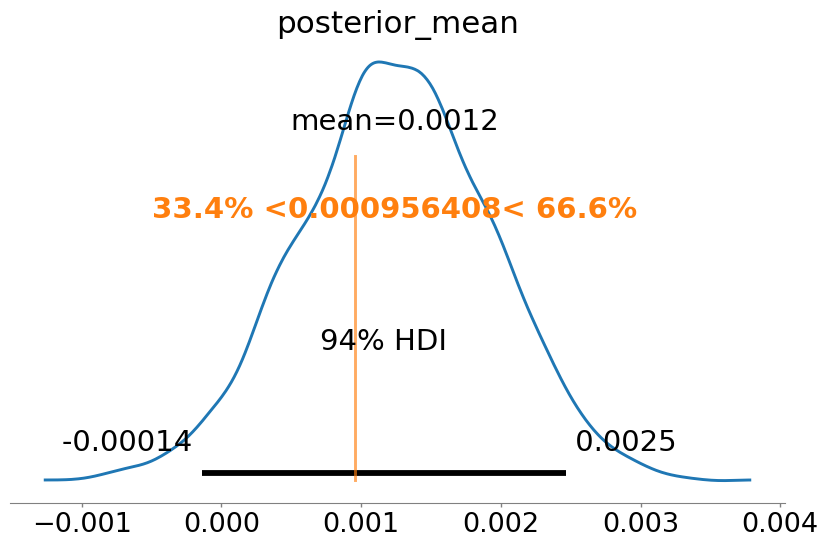

In [74]:
az.plot_posterior(idata_3ms_perp, var_names=['posterior_mean'], figsize=(10,6), ref_val=0.0009564078)
plt.plot()

Sampling: [y]
INFO	pymc.sampling.forward:forward.py:sample_posterior_predictive()- Sampling: [y]


Output()

(-0.2, 0.2)

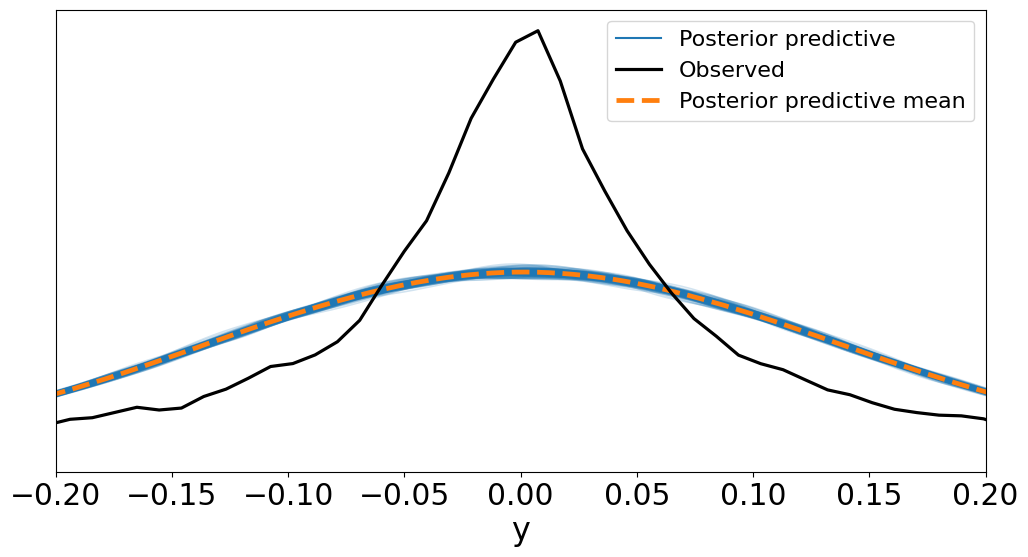

In [75]:
pm.sample_posterior_predictive(idata_3ms_perp, model=model_3ms_perp, random_seed=42)
ax = az.plot_ppc(idata_3ms_perp, num_pp_samples=200, figsize=(12,6))
ax.set_xlim(-0.2,0.2)

In [76]:
features = [
    'timedelta_ms_perp',
    'mid_price_perp',
    'trade_direction_perp',
]
target = 'window_5_pct_change_perp'

df_model = df_final_merged[features + [target]].dropna().reset_index(drop=True)

df_sample = df_model.sample(30000, random_state=42)
df_sample.head()

# X_data = df_sample[features].values
scaler = StandardScaler()
X_data = scaler.fit_transform(df_sample[features].values)
y_data = df_sample[target].values

with pm.Model() as model_5ms_perp:
    # priors
    a = pm.Normal('a', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X_data.shape[1])
    sigma = pm.HalfNormal('sigma', 1)

    # linear model
    u = pm.Deterministic('mu', a+pm.math.dot(X_data, beta))

    # likelihood
    y_pred = pm.Normal('y', mu=u, sigma=sigma, observed=y_data)

    # inference
    idata_5ms_perp = pm.sample(idata_kwargs={'log_likelihood':True})
    idata_5ms_perp.extend(pm.sample_posterior_predictive(idata_5ms_perp))

Initializing NUTS using jitter+adapt_diag...
INFO	pymc.sampling.mcmc:mcmc.py:init_nuts()- Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO	pymc.sampling.mcmc:mcmc.py:sample()- Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, sigma]
INFO	pymc.sampling.mcmc:mcmc.py:_print_step_hierarchy()- NUTS: [a, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
INFO	pymc.sampling.mcmc:mcmc.py:_sample_return()- Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]
INFO	pymc.sampling.forward:forward.py:sample_posterior_predictive()- Sampling: [y]


Output()

In [77]:
features = [
    'timedelta_ms_perp',
    'mid_price_perp',
    'trade_direction_perp',
]
target = 'window_5_pct_change_perp'

df_model = df_final_merged[features + [target]].dropna().reset_index(drop=True)
df_sample = df_model.sample(30000, random_state=42)

scaler = StandardScaler()
X_data = scaler.fit_transform(df_sample[features].values)

# X_data = df_sample[features].values
y_data = df_sample[target].values

with pm.Model() as model_5ms_perp_t:
    # priors
    a = pm.Normal('a', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X_data.shape[1])
    sigma = pm.HalfNormal('sigma', 1)

    v_ = pm.Exponential("v_", 1/9) 
    v = pm.Deterministic("v", v_+1) # weakly informative prior

    # linear model
    u = pm.Deterministic('mu', a+pm.math.dot(X_data, beta))

    # likelihood
    y_pred = pm.StudentT('y', mu=u, sigma=sigma, nu=v, observed=y_data)

    # inference
    idata_5ms_perp_t = pm.sample(idata_kwargs={'log_likelihood':True})
    idata_5ms_perp_t.extend(pm.sample_posterior_predictive(idata_5ms_perp_t))

Initializing NUTS using jitter+adapt_diag...
INFO	pymc.sampling.mcmc:mcmc.py:init_nuts()- Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO	pymc.sampling.mcmc:mcmc.py:sample()- Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, sigma, v_]
INFO	pymc.sampling.mcmc:mcmc.py:_print_step_hierarchy()- NUTS: [a, beta, sigma, v_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
INFO	pymc.sampling.mcmc:mcmc.py:_sample_return()- Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Sampling: [y]
INFO	pymc.sampling.forward:forward.py:sample_posterior_predictive()- Sampling: [y]


Output()

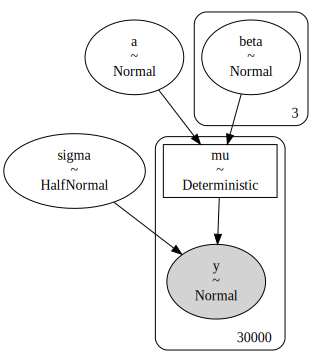

In [78]:
pm.model_to_graphviz(model_5ms_perp)

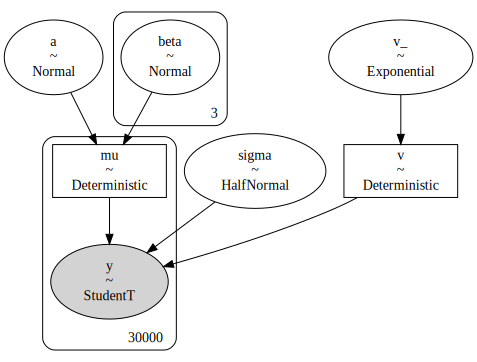

In [79]:
pm.model_to_graphviz(model_5ms_perp_t)

/home/lucky/anaconda3/envs/python311/lib/python3.11/site-packages/arviz/utils.py:146: UserWarning:

Items starting with ~: ['posterior_mean'] have not been found and will be ignored



[]

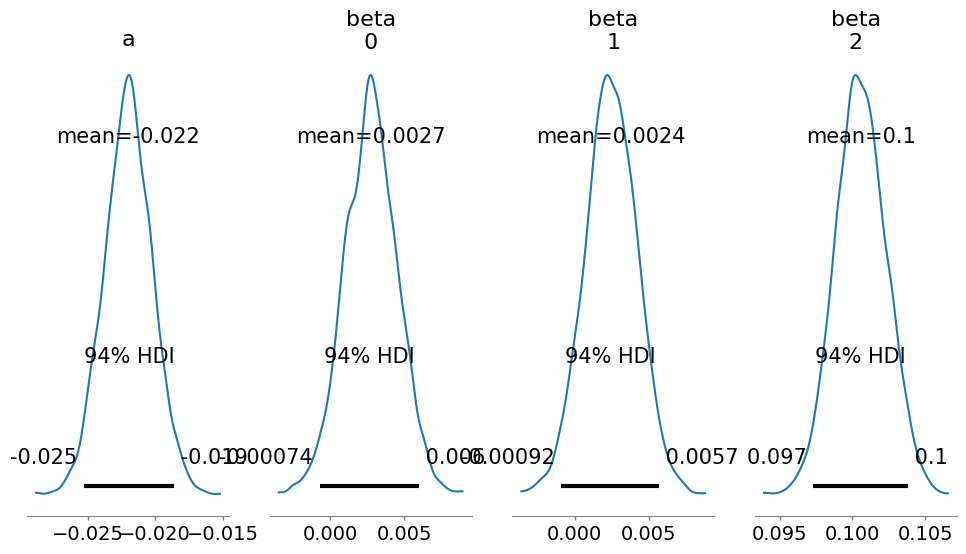

In [80]:
az.plot_posterior(idata_5ms_perp, var_names=['~posterior_mean','~mu','~sigma'], figsize=(12,6))
plt.plot()

[]

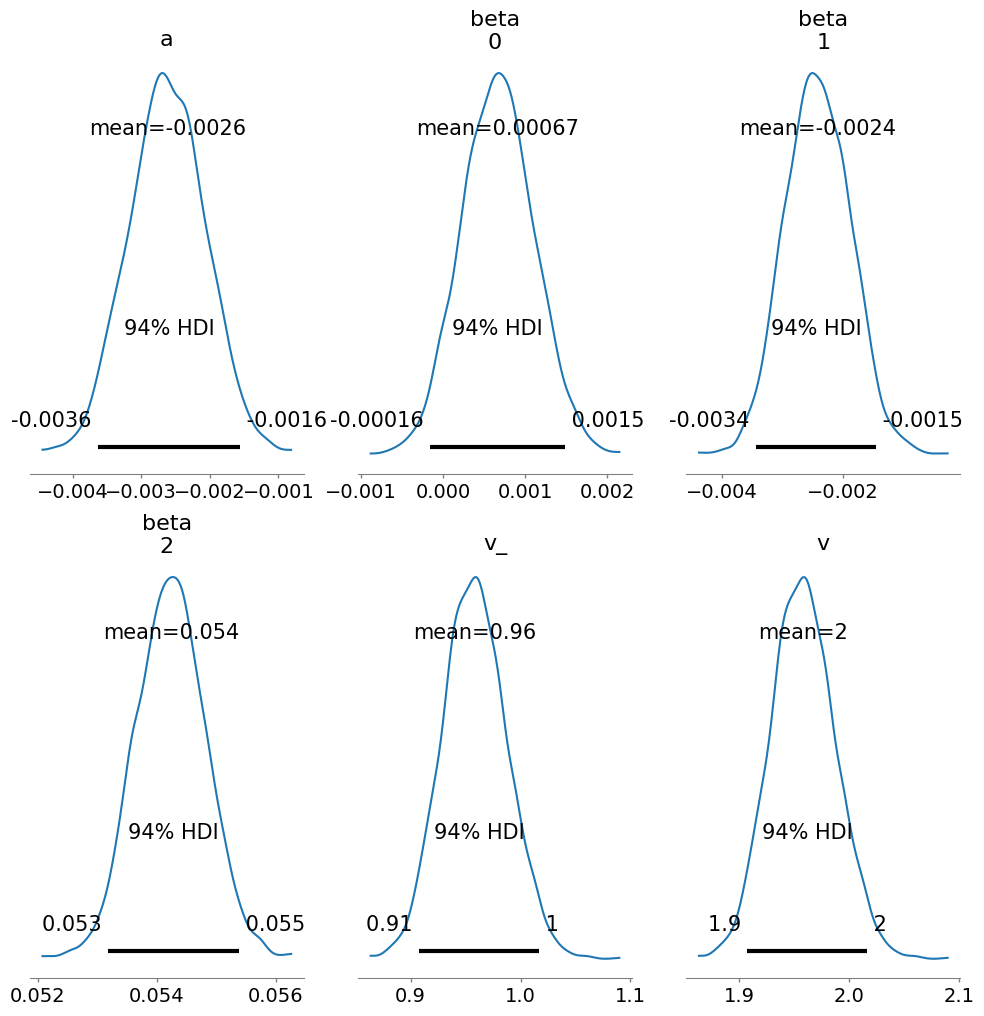

In [81]:
az.plot_posterior(idata_5ms_perp_t, var_names=['~posterior_mean','~mu','~sigma'], figsize=(12,12))
plt.plot()

[]

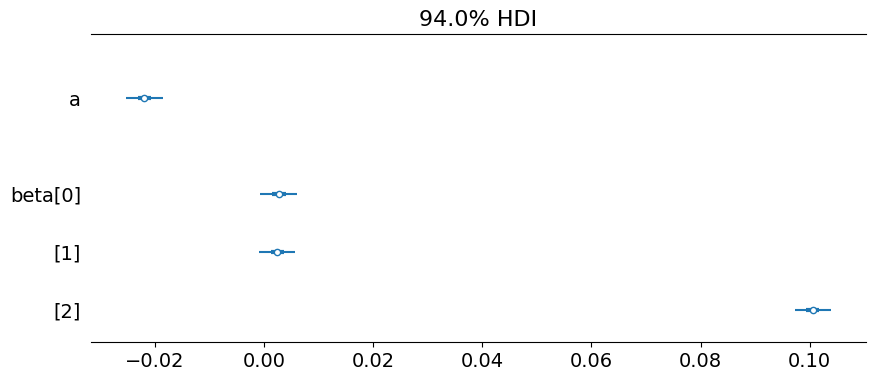

In [82]:
az.plot_forest(idata_5ms_perp, var_names=['a', 'beta'], combined=True, figsize=(10,4))
plt.plot()

[]

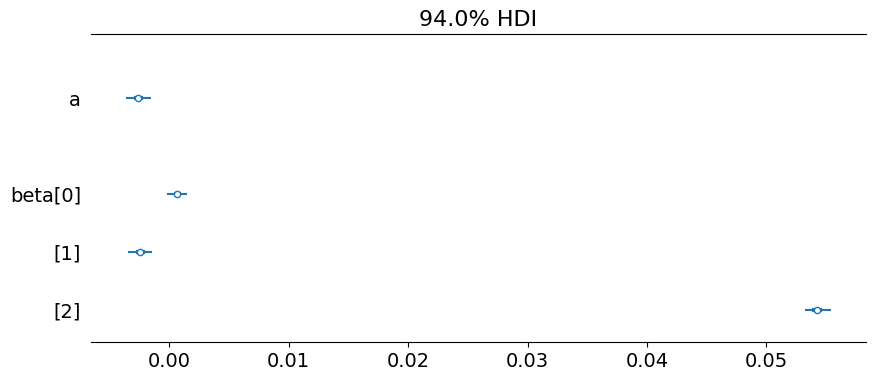

In [83]:
az.plot_forest(idata_5ms_perp_t, var_names=['a', 'beta'], combined=True, figsize=(10,4))
plt.plot()

In [84]:
mu_mean = idata_5ms_perp.posterior["mu"].mean(dim=("mu_dim_0"))  # shape: [chain, draw]
idata_5ms_perp.posterior['posterior_mean'] = mu_mean

In [85]:
az.summary(idata_5ms_perp, var_names=['a', 'beta', 'sigma','posterior_mean'], round_to=5, kind='stats')

,mean,sd,hdi_3%,hdi_97%
a,-0.02201,0.00178,-0.02530,-0.01858
beta[0],0.00273,0.00179,-0.00074,0.00603
beta[1],0.00245,0.00176,-0.00092,0.00569
beta[2],0.10057,0.00175,0.09731,0.10383
sigma,0.30483,0.00125,0.30247,0.30721
posterior_mean,-0.02201,0.00178,-0.02530,-0.01858


In [86]:
mu_mean = idata_5ms_perp_t.posterior["mu"].mean(dim=("mu_dim_0"))  # shape: [chain, draw]
idata_5ms_perp_t.posterior['posterior_mean'] = mu_mean

az.summary(idata_5ms_perp_t, var_names=['a', 'beta', 'sigma','posterior_mean'], round_to=5, kind='stats')

,mean,sd,hdi_3%,hdi_97%
a,-0.00262,0.00056,-0.00363,-0.00156
beta[0],0.00067,0.00044,-0.00016,0.00148
beta[1],-0.00242,0.00054,-0.00344,-0.00146
beta[2],0.05423,0.00059,0.05318,0.05537
sigma,0.07418,0.00062,0.07301,0.07533
posterior_mean,-0.00262,0.00056,-0.00363,-0.00156


In [87]:
perp_population_mean_5pct_change = np.mean(df_final_merged['window_5_pct_change_perp']) * 100
print(f"Mean percentage change of spot population: {perp_population_mean_5pct_change:.8f}%")

Mean percentage change of spot population: -2.28991941%


[]

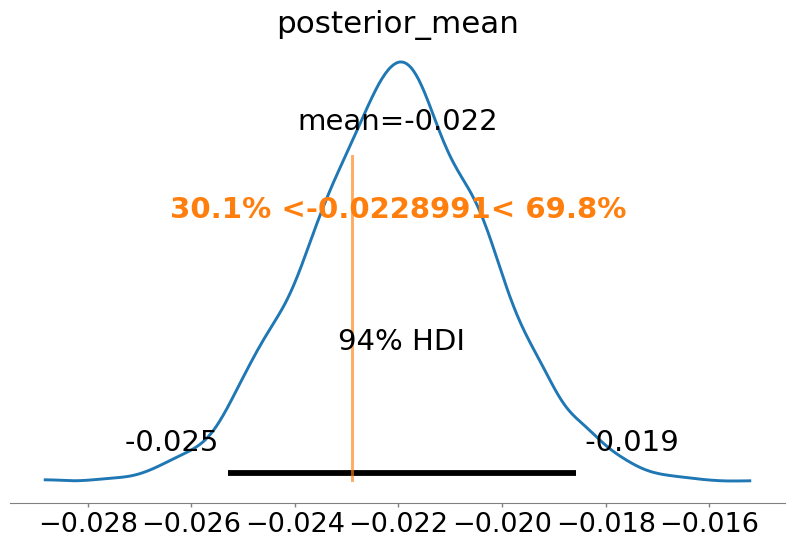

In [88]:
az.plot_posterior(idata_5ms_perp, var_names=['posterior_mean'], figsize=(10,6), ref_val= -0.0228991)
plt.plot()

[]

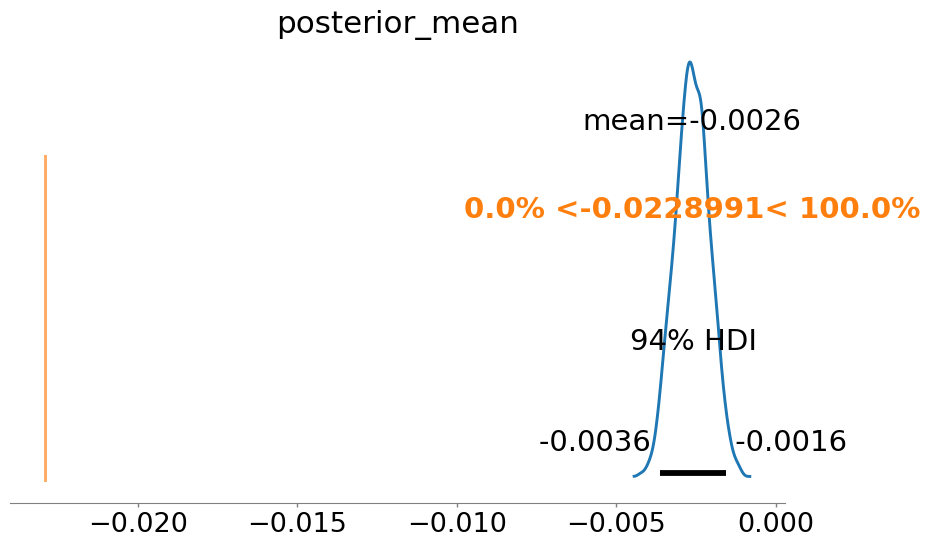

In [89]:
az.plot_posterior(idata_5ms_perp_t, var_names=['posterior_mean'], figsize=(10,6), ref_val= -0.0228991)
plt.plot()

Sampling: [y]
INFO	pymc.sampling.forward:forward.py:sample_posterior_predictive()- Sampling: [y]


Output()

(-0.2, 0.2)

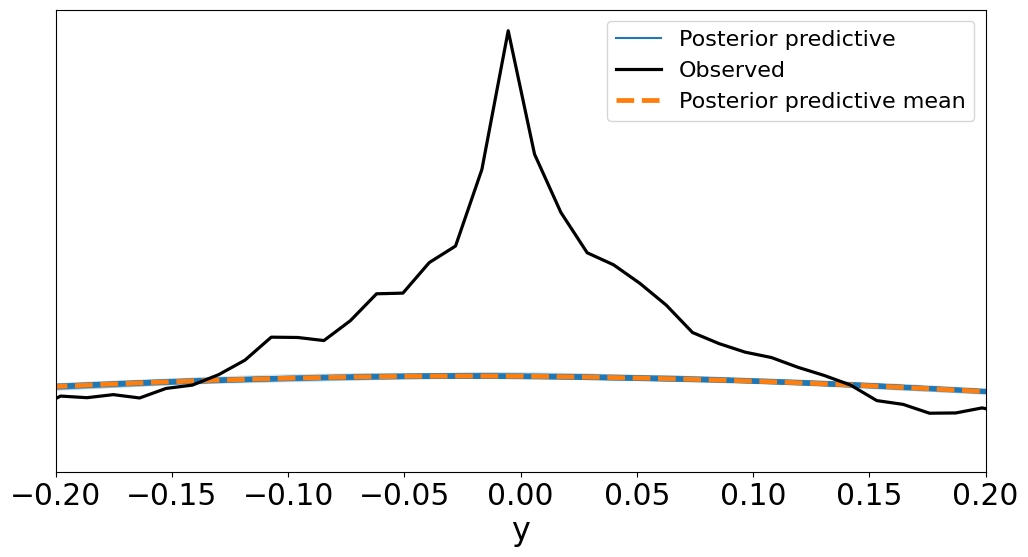

In [90]:
pm.sample_posterior_predictive(idata_5ms_perp, model=model_5ms_perp, random_seed=42)
ax = az.plot_ppc(idata_5ms_perp, num_pp_samples=200, figsize=(12,6))
ax.set_xlim(-0.2,0.2)

Sampling: [y]
INFO	pymc.sampling.forward:forward.py:sample_posterior_predictive()- Sampling: [y]


Output()

(-0.2, 0.2)

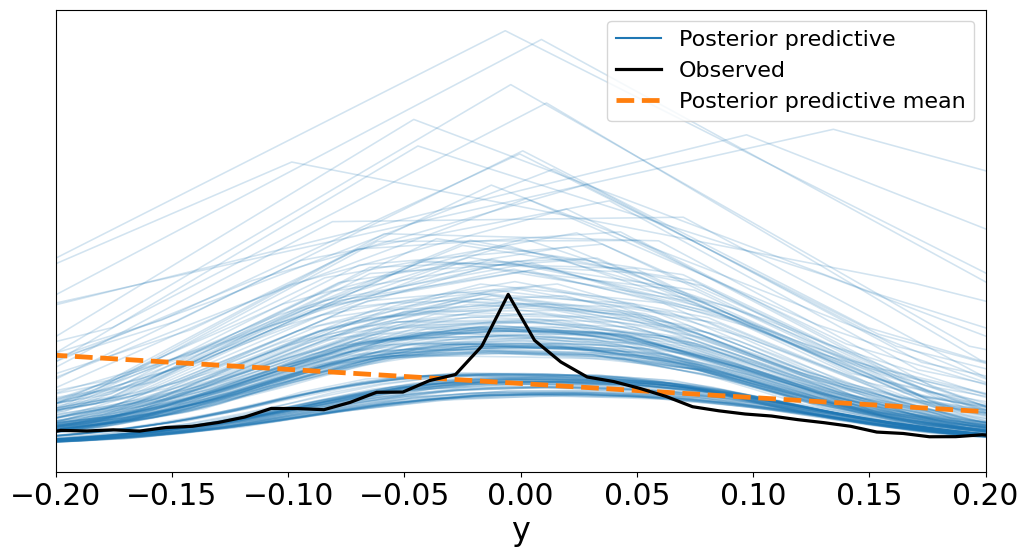

In [91]:
pm.sample_posterior_predictive(idata_5ms_perp_t, model=model_5ms_perp_t, random_seed=42)
ax = az.plot_ppc(idata_5ms_perp_t, num_pp_samples=200, figsize=(12,6))
ax.set_xlim(-0.2,0.2)

[]

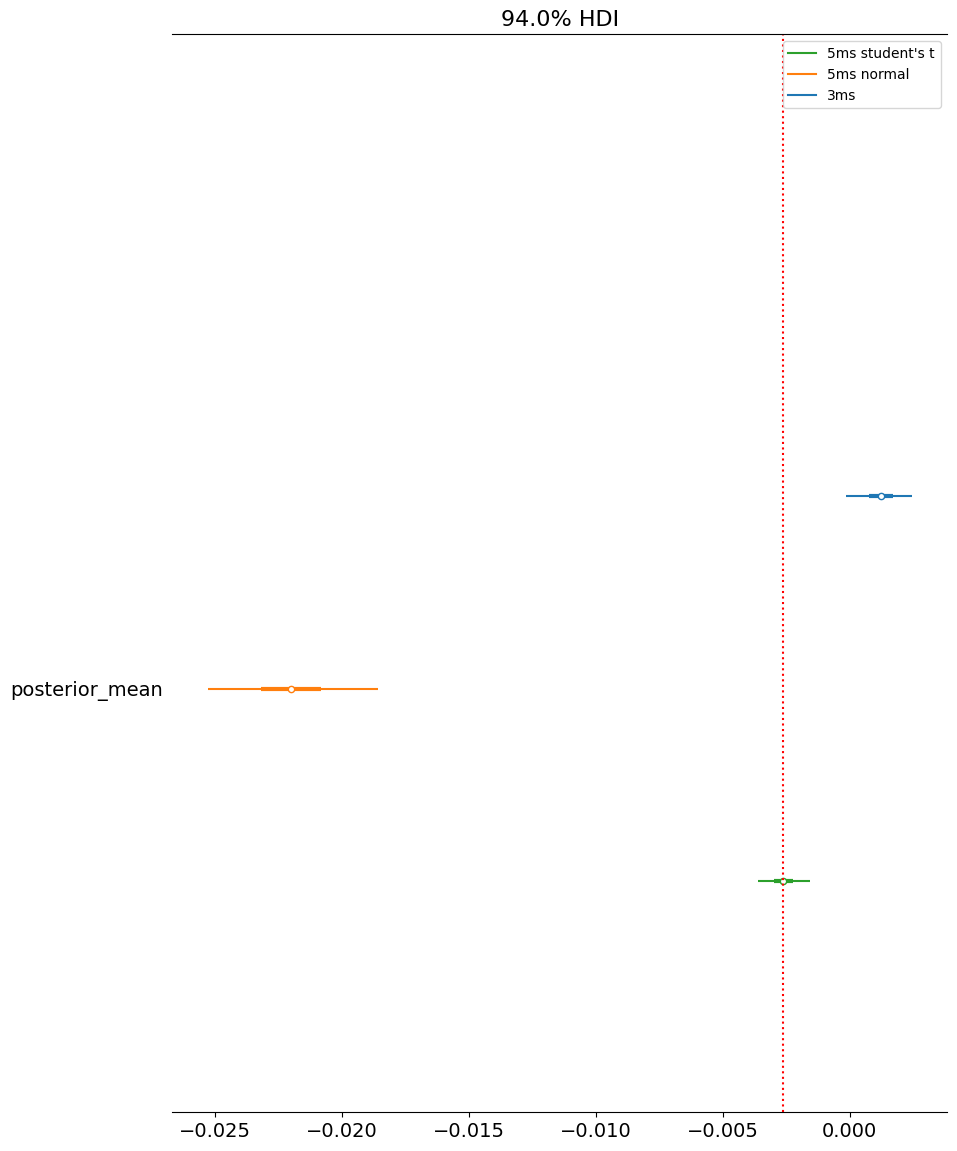

In [92]:
axes = az.plot_forest(data=[idata_3ms_perp, idata_5ms_perp, idata_5ms_perp_t], 
               model_names=['3ms','5ms normal', "5ms student's t"], figsize=(10,14),
               combined=True,
               var_names=['posterior_mean'],
               r_hat=False,
               ess=False
              )

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_5ms_perp_t.posterior['posterior_mean'].mean(), *y_lims, color='red', ls=":")
plt.plot()

In [93]:
compare = az.compare(dict(model_3ms=idata_3ms_perp, model_5ms_l=idata_5ms_perp, model_5ms_t=idata_5ms_perp_t),ic='loo')

In [94]:
compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_3ms,0,21532.998095,60.902408,0.000000,0.707359,929.663370,0.000000,False,log
model_5ms_t,1,18864.391446,6.152235,2668.606650,0.292641,230.377910,958.847758,False,log
model_5ms_l,2,-6948.793867,46.231263,28481.791962,0.000000,803.488645,1229.928309,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

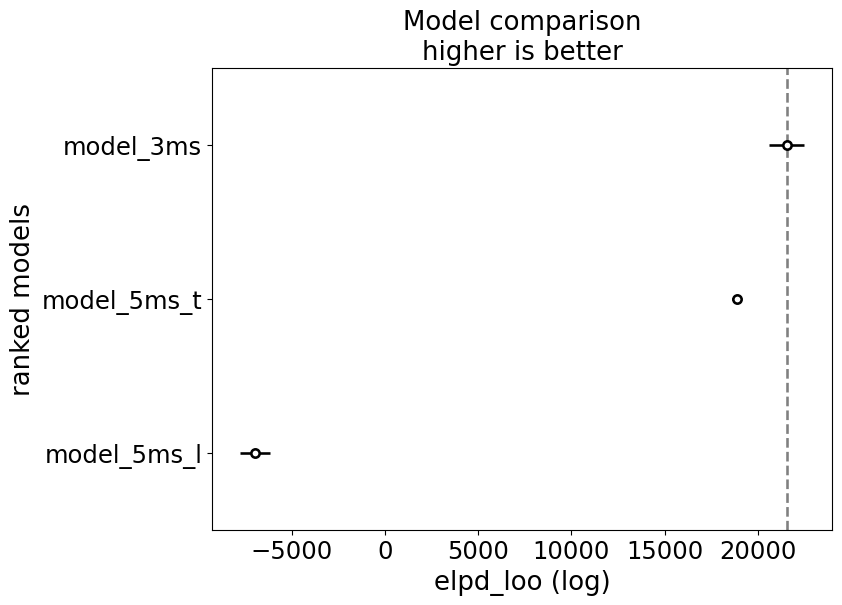

In [95]:
az.plot_compare(compare, figsize=(8,6))

In [96]:
df_final_merged.to_csv('./data/df_final_merged.csv', index=False)

## Conclusion

Based on the data and model, I conclude the following:
- The best model is linear regression (% change within 3ms window) with normal likelihood
- That best model was selected based on visual diagnostics and statistical summaries, including model ranking by expected log pointwise predictive density (ELPD) estimated via Pareto smoothed importance sampling leave-one-out cross-validation (LOO)
- For spot market, the estimated percentage change within 3ms window is likely to be -0.437%, with a 94% probability that the true value lies between -0.587% and -0.308%
- For perpetual market, the estimated percentage change within 3ms window is likely to be 0.123%, with a 94% probability that the true value lies between -0.001% and +0.247%
- The most influential predictor in the spot market model is beta2 (price_dev) with an estimated coefficient of 0.03135 and 94% HDI between 0.02800 and 0.03471. However, this variable shows greater uncertainty compared to others.
- The most influential predictor for perpetual market model is beta2 (trade_direction) with an estimated coefficient of 0.05576	and 94% HDI between 0.05451 and	0.05712
- According to the 94% HDI of percentage change in the spot and perpetual markets, there are two sudden price changes as follows:
  - Spot Market: any 3ms window percentage change outside the 94% HDI (i.e., less than -0.587% or greater than -0.308%).
  - Perpetual Market: any 3ms window percentage change outside the 94% HDI (i.e., less than -0.001% or greater than +0.247%).